# Sentiment Analysis on Movie Reviews

# Contents <a id='back'></a>
* [1. Introduction](#intro)
* [2. Data Exploration and Preprocessing](#data_exploration)
* [3. Exploratory Data Analysis (EDA)](#eda)
    * [3.1 Number of Movies and Reviews Per Year](#movies_and_reviews)
    * [3.2 Distribution of Number of Reviews per Movie](#review_per_movie)
    * [3.3 The Top 10 Genres](#top_10_genres)
    * [3.4 Distributions of Ratings in Train and Test Sets](#rating_dist)
    * [3.5 Distributions of Number of Reviews in Train and Test Sets](#review_dist)
    * [3.6 Distribution of Target Classes](#class_dist)
* [4. Modeling](#modeling)
    * [4.1 Text Normalisation](#text_normalisation)
    * [4.2 Train / Test Split](#train_test_split)
    * [4.3 Model Development and Evaluation](#model_dev_eval)
        * [4.3.1 NLTK / Bag-of-Words](#nltk_bow)
        * [4.3.2 NLTK / TF-IDF](#nltk_tfidf)
        * [4.3.3 spaCy/ TF-IDF](#spacy_tfidf)
        * [4.3.4 BERT](#bert)
    * [4.4 Final Evaluation](#final_eval)
* [5. My Reviews](#my_reviews)
* [6. Model Deployment](#model_deployment)
* [7. General Conclusion](#general_conclusion)

## 1. Introduction <a id='intro'></a>

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorising movie reviews to detect negative reviews. 

### 1.1 Purpose

To build a model for classifying positive and negative reviews by using a dataset of IMBD movie reviews with polarity labelling. **The model should have a F1 score of at least 0.85.**

In [1]:
# Data preprocessing and manipulation
import pandas as pd
import numpy as np
import math
import re
import pickle
from pathlib import Path

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing in NLP
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import torch
import transformers

# Classification models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model evaluation and selection
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold
from optunaopt import sklearn_opt, keras_opt
import time

# Show progress bar
from tqdm.auto import tqdm

# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

In [3]:
# Enable progress_apply function
tqdm.pandas()

[Back to Contents](#back)

## 2. Data Exploration and Preprocessing <a id='data_exploration'></a>

In [4]:
# Load the dataset
try:
    data = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    data = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Have a look at the dataset
data.head()

tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage implies that Warren Beatty and Gold...       1  neg    0   
1  How the hell did they get this made?! Presenti...       1  neg    0   
2  There is no real story the film seems more lik...       3  neg    0   
3  Um .... a serious film about troubled teens in...       7  pos    1   
4  I'm totally agree with GarryJohal from Singapo...       9  pos    1   

  ds_part   idx  
0   train  8335  
1   train  8336  
2    test  2489  
3    test  9280  
4    test  9281

In [6]:
# Check the shape
data.shape

(47331, 17)

In [7]:
# List the column names
data.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')

The dataset has 47331 rows (reviews) and 16 columns of information related to each review.

**Description of data**
- `tconst`: A unique identifier for each movie in the IMDb database.
- `title_type`: The type or category of the title (e.g movis).
- `primary_title`: The primary title of the movie.
- `original_title`: The original title of the movie (in its original language).
- `start_year`: The year when the movie was released or started.
- `end_year`: The year when the movie ended (if applicable).
- `runtime_minutes`: The duration of the movie in minutes.
- `is_adult`: A binary indicator (1 or 0) indicating whether the movie is classified as "adult."
- `genres`: The genres associated with the movie.
- `average_rating`: The average rating given to the movie.
- `votes`: The number of votes the movie hasvie review.
- `rating`: The rating given in the review.
- `sp`: Sentiment polar orty (posittive, neutral) o
- `ds_part`: The part of the dataset (train or test).
- `idx`: An identifier for the data point in the dataset.

***Feature***
- `review`: The movie review in text.

***Target***
- `pos`: A binary indicator (1 or 0) indicating the sentiment polarity of the review.

In [8]:
# Check for duplicates
data.duplicated().sum()

0

In [9]:
# Check for missing values
data.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

There are two missing values in the `average_rating` and `votes` columns. These missing values will not be dealt with since the main objective of this project is to develop a classifier with the `review` and `pos` data.

In [10]:
data[['start_year', 'genres', 'average_rating', 'rating', 'review', 'pos']].describe(include='all')

start_year genres  average_rating        rating  \
count   47331.000000  47331    47329.000000  47331.000000   
unique           NaN    585             NaN           NaN   
top              NaN  Drama             NaN           NaN   
freq             NaN   3392             NaN           NaN   
mean     1989.631235    NaN        5.998278      5.484608   
std        19.600364    NaN        1.494289      3.473109   
min      1894.000000    NaN        1.400000      1.000000   
25%      1982.000000    NaN        5.100000      2.000000   
50%      1998.000000    NaN        6.300000      4.000000   
75%      2004.000000    NaN        7.100000      9.000000   
max      2010.000000    NaN        9.700000     10.000000   

                                                   review           pos  
count                                               47331  47331.000000  
unique                                              47240           NaN  
top     Loved today's show!!! It was a variety and not...           NaN  
freq                                                    5           NaN  
mean                                                  NaN      0.498954  
std                                                   NaN      0.500004  
min                                                   NaN      0.000000  
25%                                                   NaN      0.000000  
50%                                                   NaN      0.000000  
75%                                                   NaN      1.000000  
max                                                   NaN      1.000000

In [11]:
# Check the number of duplicates in the review column
data['review'].duplicated().sum()

91

The movies are ranged from the year 1894 to the year 2010. The `drama` genre has the top count in the dataset. The average rating and rating are scores from 0 to 10. The mean of 0.499 in the `pos` column shows that the positive and negative polarity labels are roughly the same. There are 91 duplicated reviews in the dataset and they will be removed.

In [12]:
# Drop the duplicates
data.drop_duplicates(subset=['review'], inplace=True)

# Check if the duplicates have been dropped
data['review'].duplicated().sum()

0

[Back to Contents](#back)

## 3. Exploratory Data Analysis (EDA) <a id='eda'></a>

### 3.1 Number of Movies and Reviews Per Year <a id='movies_and_reviews'></a>

In [13]:
# Prepare the data to be plotted
# Number of movies over years
df_t1 = data[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
df_t1 = df_t1.reindex(index=np.arange(df_t1.index.min(), max(df_t1.index.max(), 2016))).fillna(0)

# Number of reviews (positive and negative) over years
df_t2 = data.groupby(['start_year', 'pos'])['pos'].count().unstack()
df_t2 = df_t2.reindex(index=np.arange(df_t2.index.min(), max(df_t2.index.max(), 2016))).fillna(0)

# Five-year rolling mean of number of reviews per movie
df_t3 = data['start_year'].value_counts().sort_index()
df_t3 = df_t3.reindex(index=np.arange(df_t3.index.min(), max(df_t3.index.max(), 2016))).fillna(0)
df_t3 = (df_t3 / df_t1).fillna(0)
df_t3 = df_t3.reset_index(drop=True).rolling(5).mean()

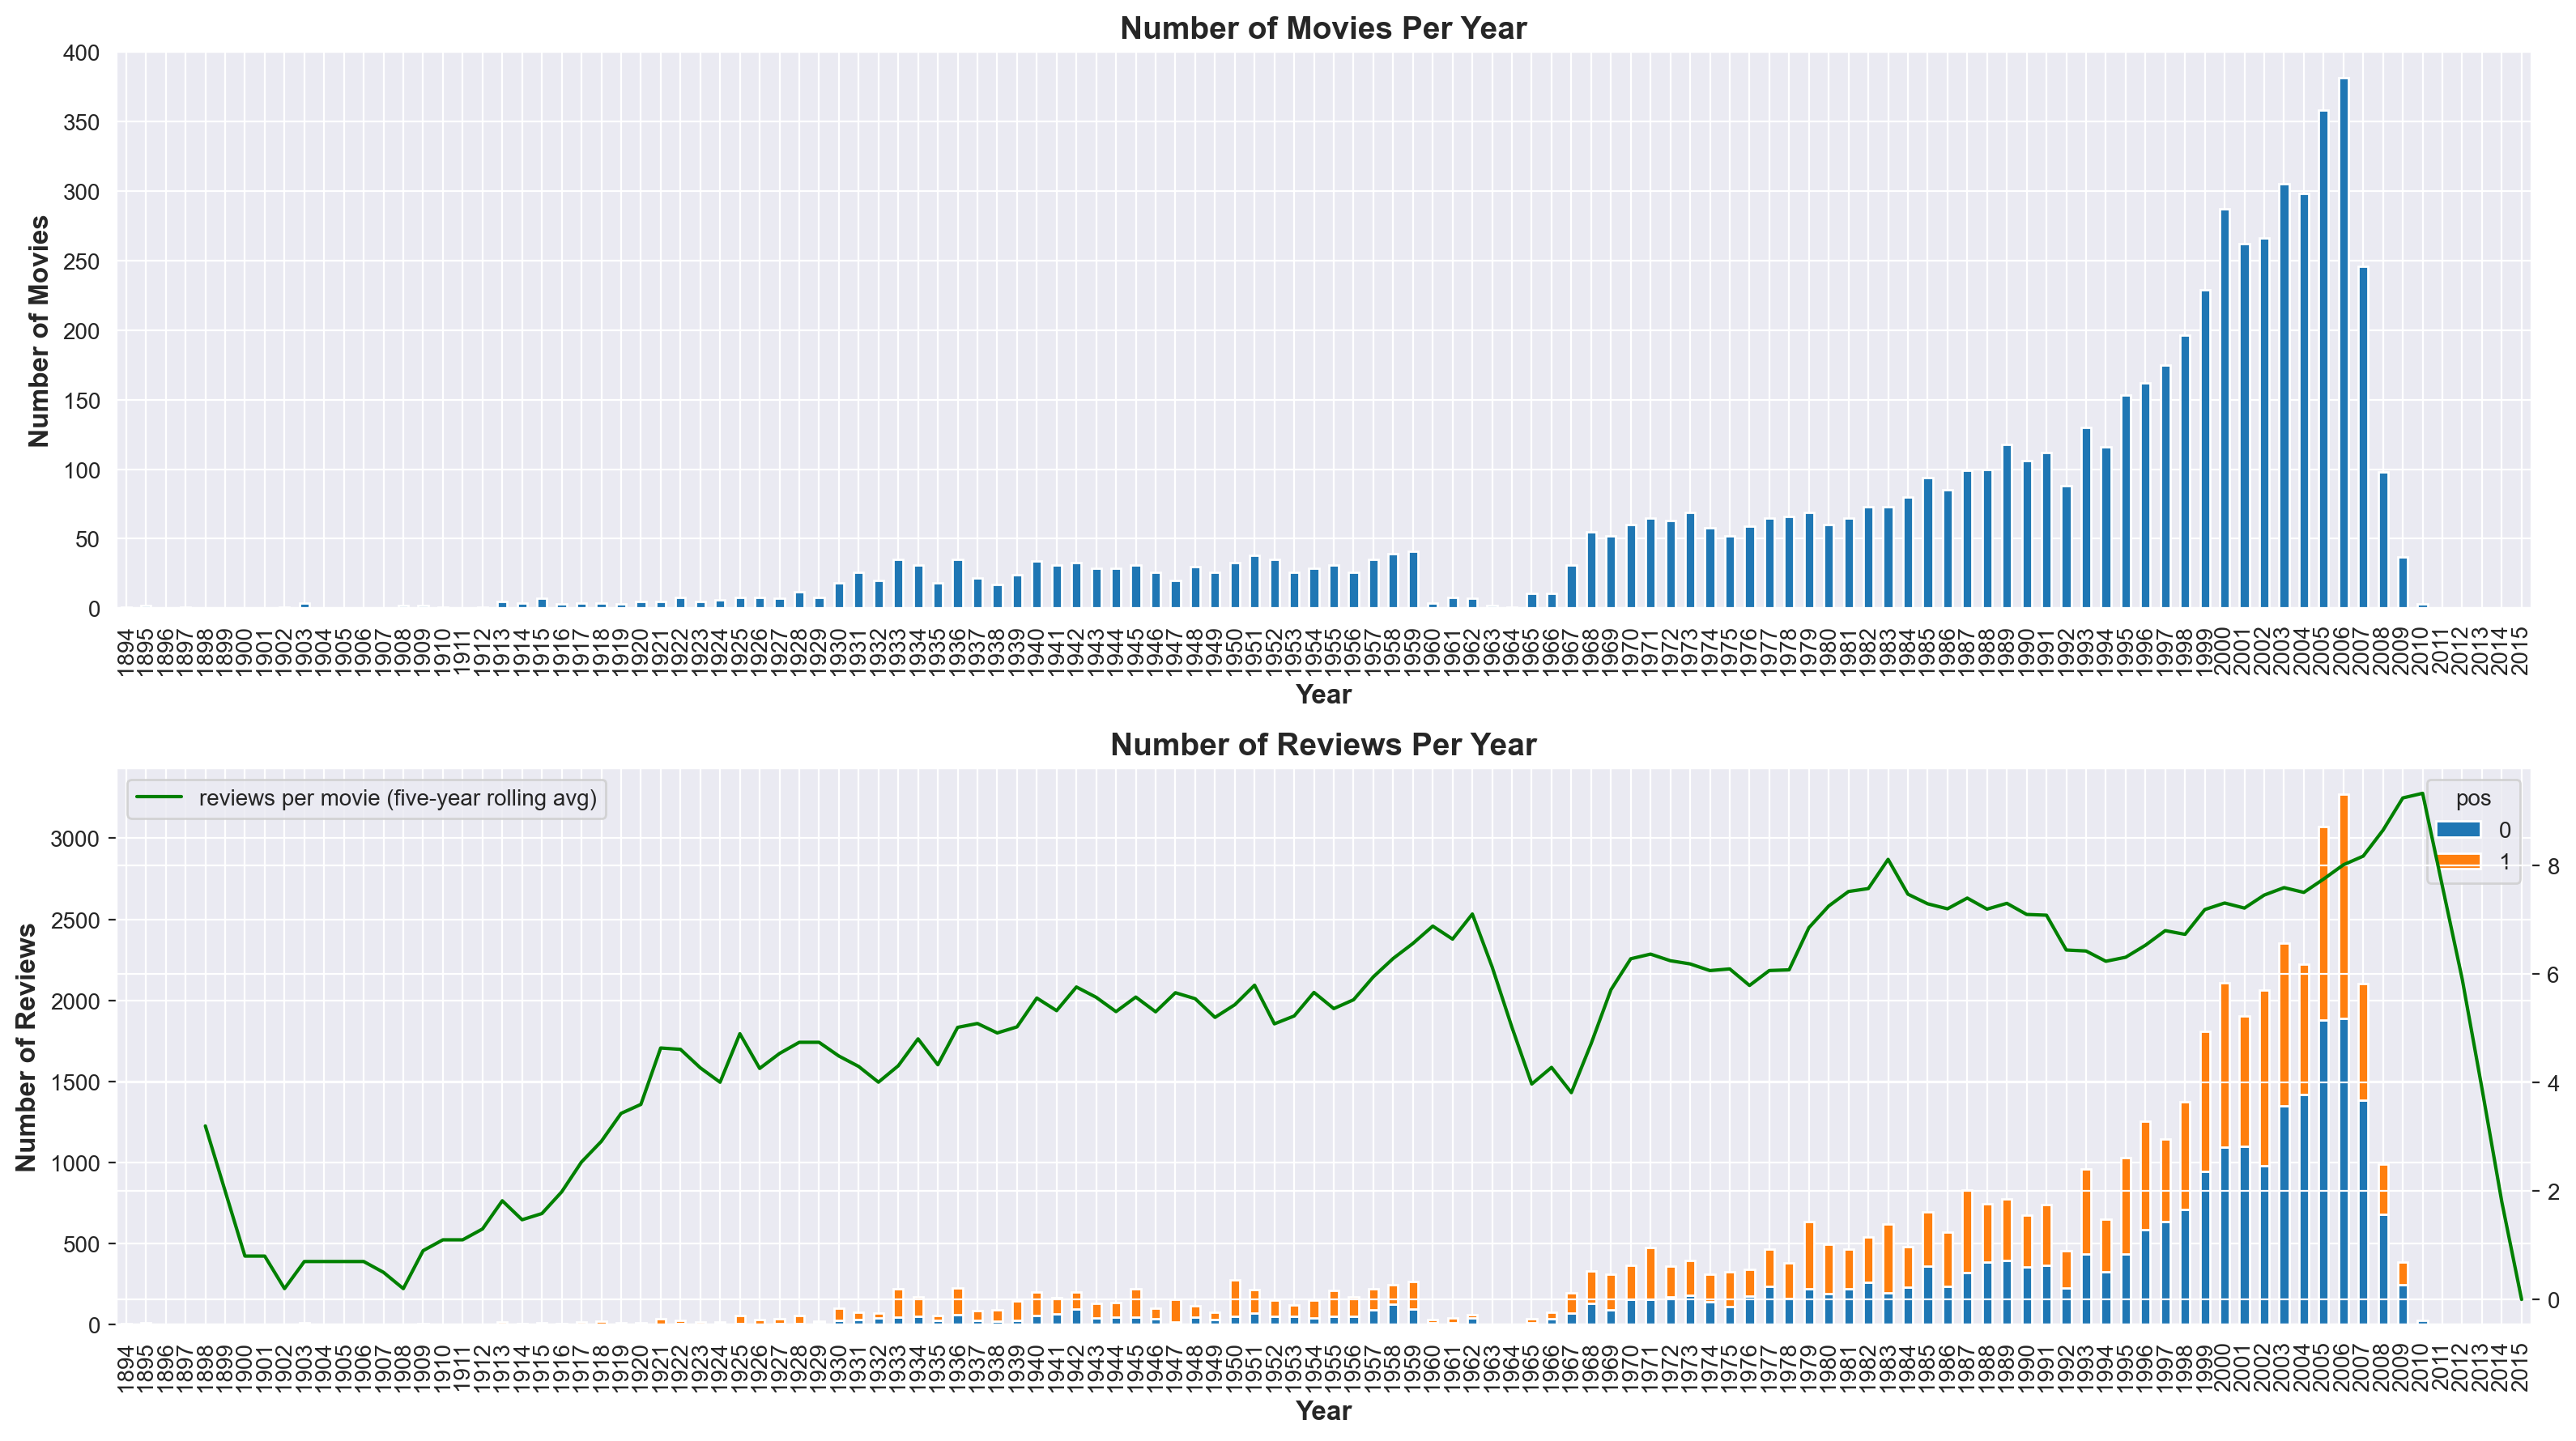

In [14]:
# Plot the graph
sns.set_style('darkgrid')
fig, axs = plt.subplots(2, 1, figsize=(16, 9))

ax = axs[0]
df_t1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Per Year', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Movies', fontsize=12, fontweight='bold')

ax = axs[1]
df_t2.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Number of Reviews Per Year', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Reviews', fontsize=12, fontweight='bold')
ax = axs[1].twinx()
df_t3.plot(color='green', label='reviews per movie (five-year rolling avg)', ax=ax)
ax.legend(loc='upper left')

fig.tight_layout()
plt.show()

- The number of movies per year was less than 50 before 1970. After 1970, the number of movies has been increasing gradually until 2006.
- The average number of reviews per movie was between 4 to 6 before 1960 and 6 to 8 after 1970.
- Starting from 1990s, there is an increasing trend in the number of reviews with negative polarity.

[Back to Contents](#back)

### 3.2 Distribution of Number of Reviews per Movie <a id='review_per_movie'></a>

In [15]:
# Prepare the data to be plotted
# Number of reviews per movie
df_t1 = data.groupby('tconst')['review'].count()

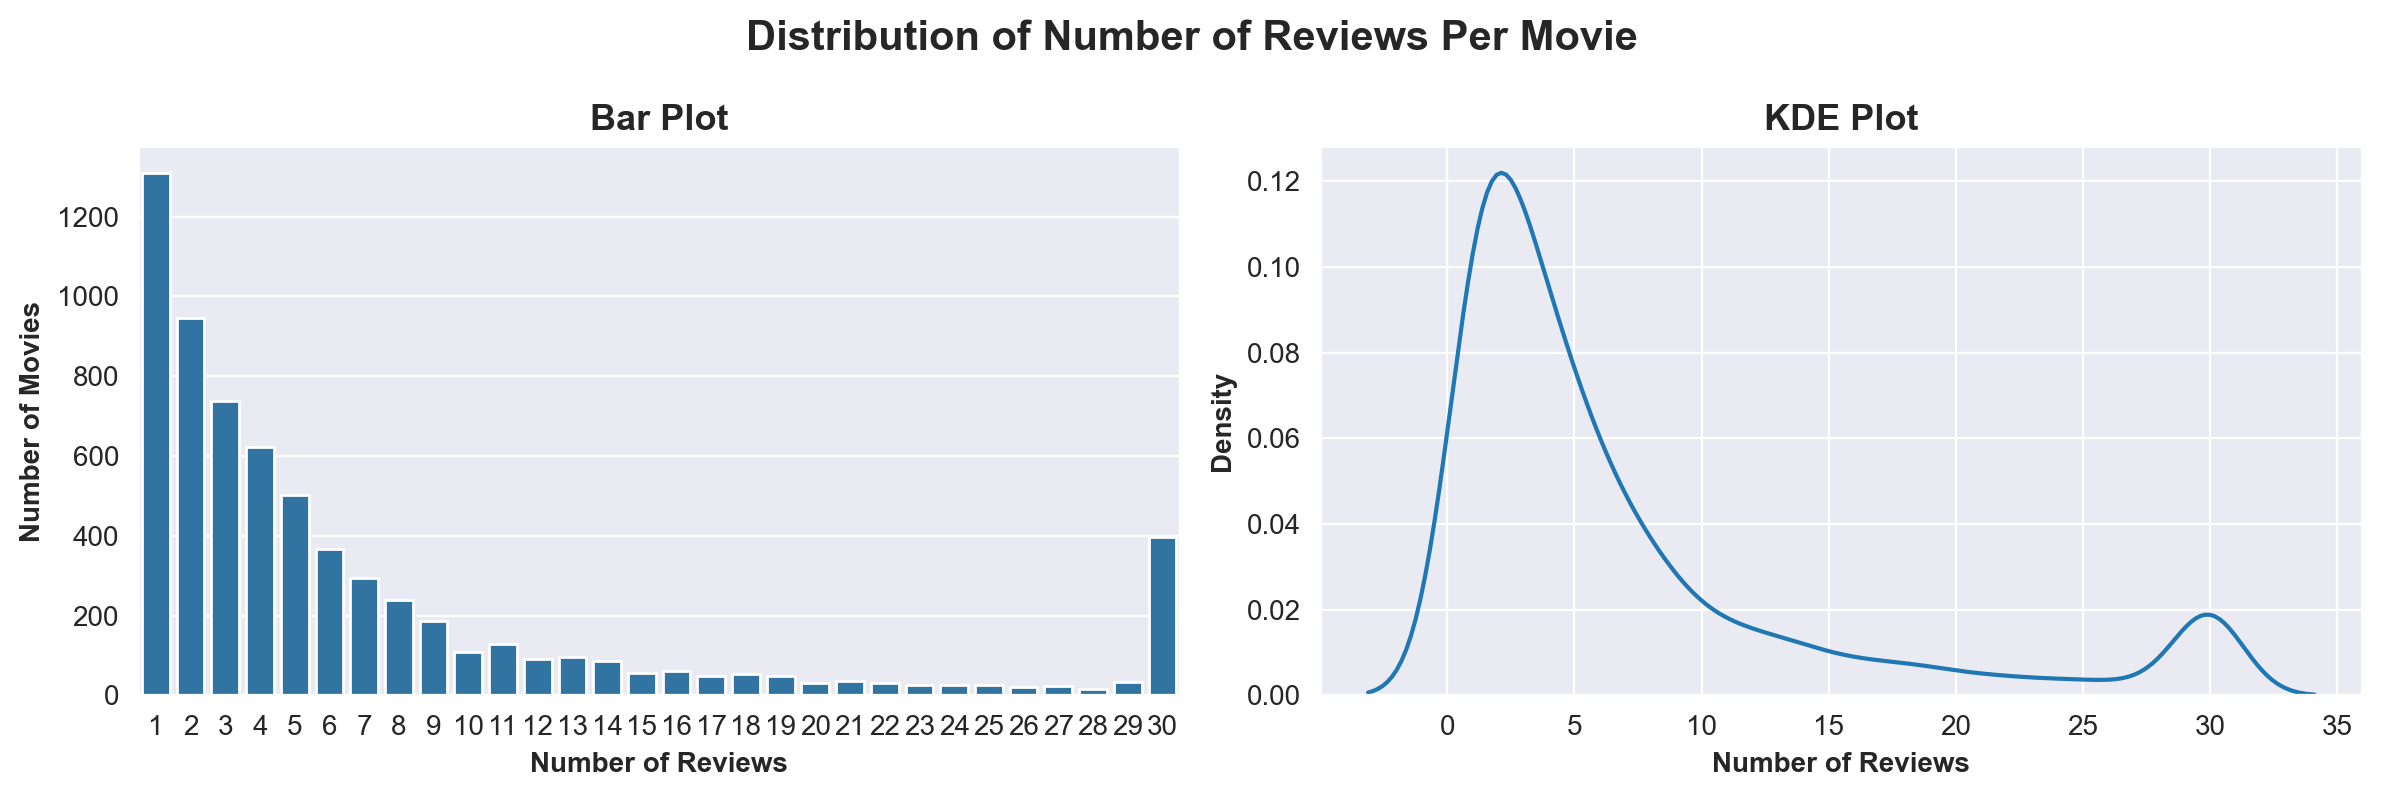

In [16]:
# Plot the bar chart and kde plot to show the distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle('Distribution of Number of Reviews Per Movie', fontsize=15, fontweight='bold')

ax = axs[0]
sns.countplot(x=df_t1.values, ax=ax)
ax.set_title('Bar Plot', fontsize=13, fontweight='bold')
ax.set_xlabel('Number of Reviews', fontweight='bold')
ax.set_ylabel('Number of Movies', fontweight='bold')

ax = axs[1]
sns.kdeplot(df_t1, ax=ax)
ax.set_title('KDE Plot', fontsize=13, fontweight='bold')
ax.set_xlabel('Number of Reviews', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')

fig.tight_layout()
plt.show()

Most of the movies have less than 10 reviews but surprisingly there are quite a lot of movies with 30 reviews.

[Back to Contents](#back)

### 3.3 The Top 10 Genres <a id='top_10_genres'></a>

In [17]:
# Prepare the data to be plotted
df_t1 = data.copy()
df_t1['genres'] = df_t1['genres'].str.split(',')

# Number of reviews in top 10 genres
df_t2 = df_t1[['genres', 'pos']].explode('genres').groupby('genres')['pos'].value_counts().unstack()
df_t2['total'] = df_t2[0] + df_t2[1]
df_t2 = df_t2.sort_values('total', ascending=False)[:10]

# Avg user rating in top 10 genres
df_t3 = df_t1[['genres', 'rating', 'pos']].explode('genres').pivot_table(index='genres', columns='pos', values='rating', aggfunc='mean')
df_t3 = df_t2[['total']].merge(df_t3, left_index=True, right_index=True)

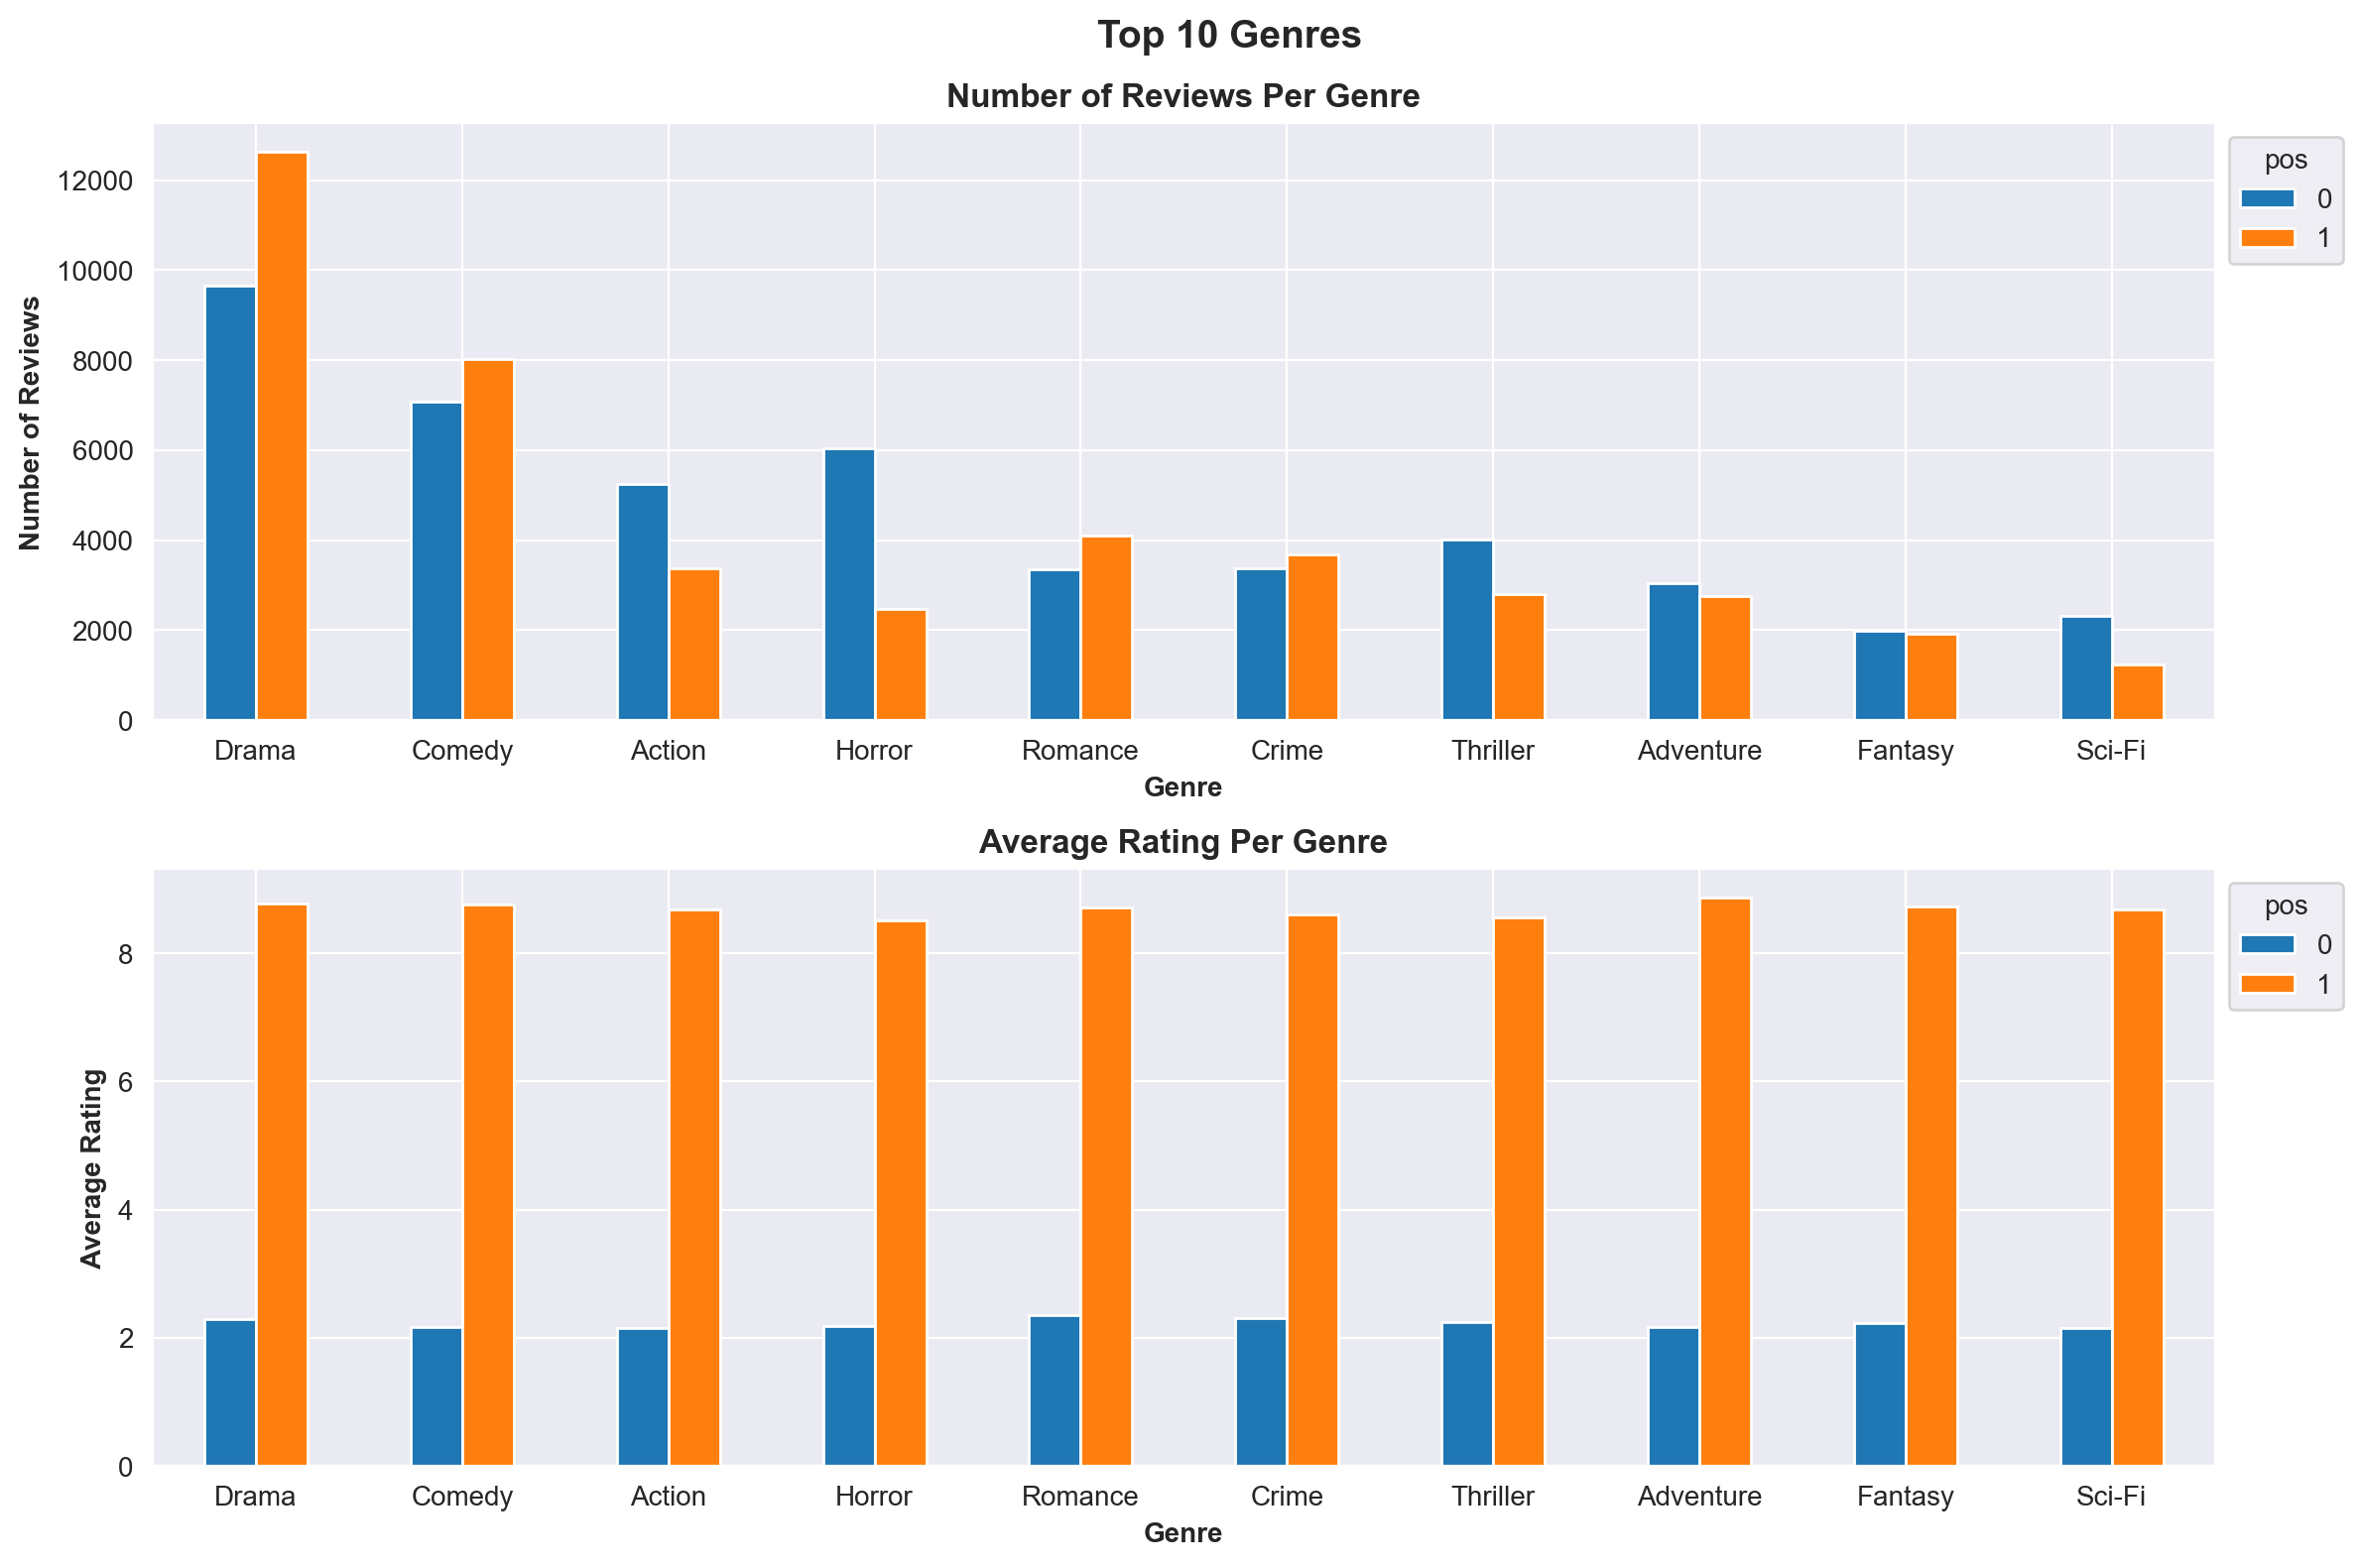

In [18]:
# Plot the bar charts
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
sns.set_style('darkgrid')

fig.suptitle('Top 10 Genres', x=0.52, fontsize=14, fontweight='bold')

ax = axs[0]
df_t2.plot(kind='bar', y=[0, 1], ax=ax)
ax.set_title('Number of Reviews Per Genre', fontsize=12, fontweight='bold')
ax.set_xlabel('Genre', fontweight='bold')
ax.set_ylabel('Number of Reviews', fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='pos', loc='upper left', bbox_to_anchor=(1, 1))

ax = axs[1]
df_t3.plot(kind='bar', y=[0, 1], ax=ax)
ax.set_title('Average Rating Per Genre', fontsize=12, fontweight='bold')
ax.set_xlabel('Genre', fontweight='bold')
ax.set_ylabel('Average Rating', fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='pos', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

- The `drama` and `comedy` are the two most popular genres and there are more positive reviews for these genres (especially the `drama`).
- The `action`, `horror`, `thriller` and `sci-fi` genres apparently have more negative reviews.
- Generally, the movies with positive reviews have significantly higher ratings than the negative ones, regardless the movie genre.

[Back to Contents](#back)

### 3.4 Distributions of Ratings in Train and Test Sets <a id='rating_dist'></a>

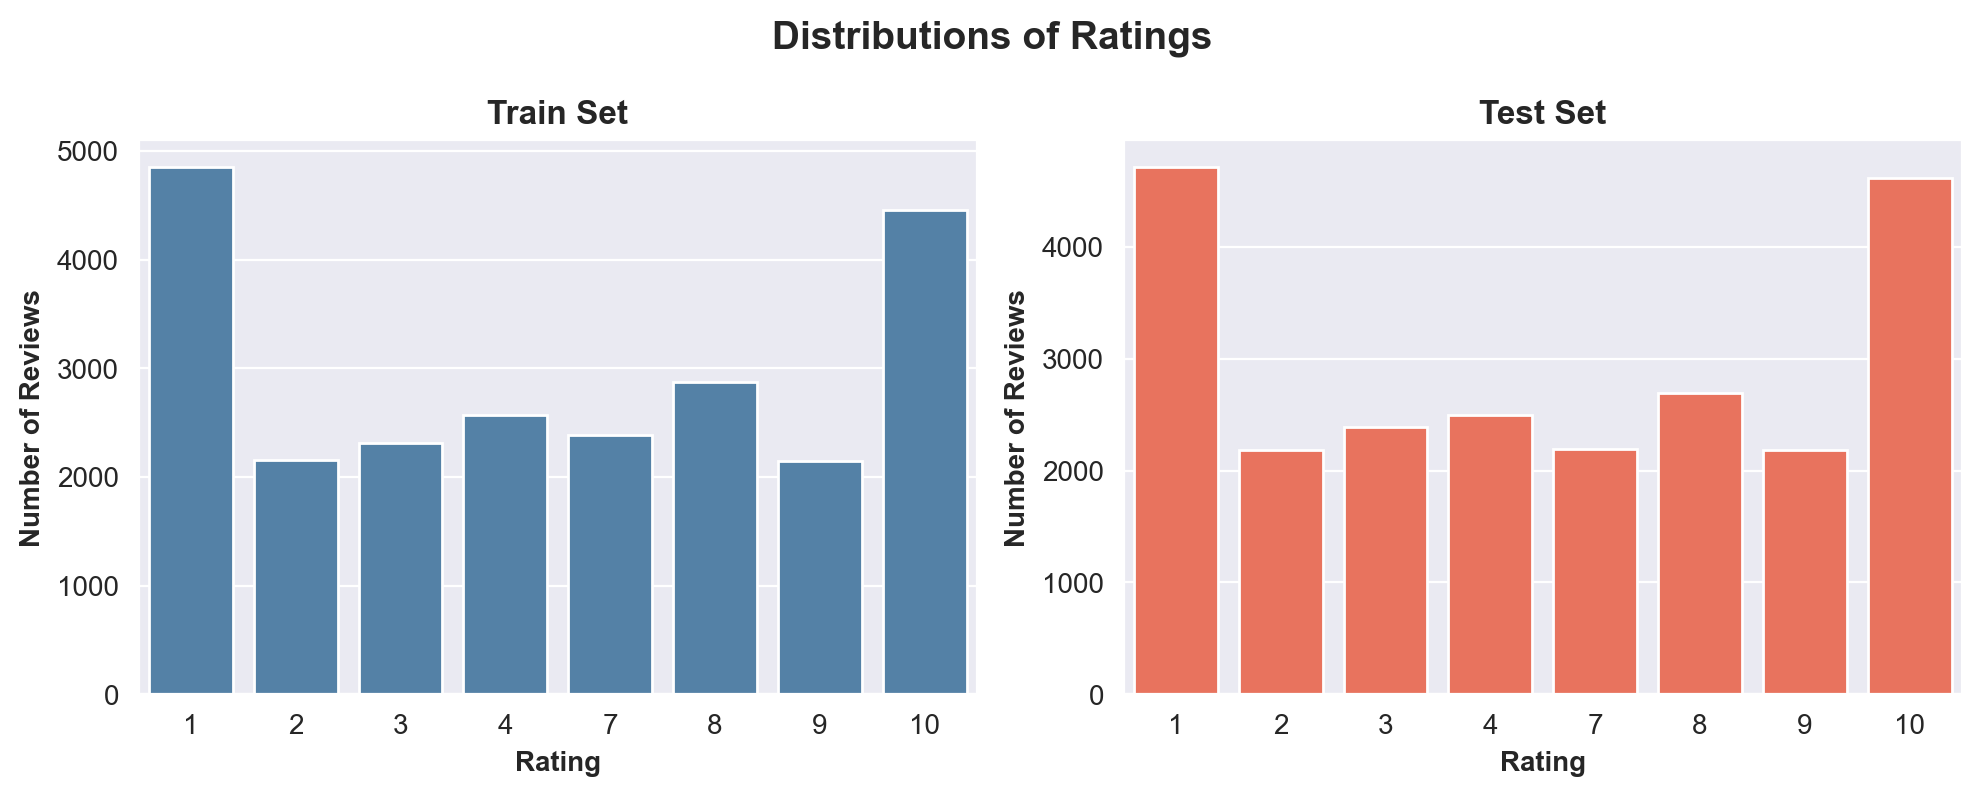

In [19]:
# Plot the distributions of ratings in train and test sets
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle('Distributions of Ratings', fontsize=14, fontweight='bold')

ax = axs[0]
sns.countplot(data=data.query('ds_part == "train"'), x='rating', color='steelblue', ax=ax)
ax.set_title('Train Set', fontsize=12, fontweight='bold')
ax.set_xlabel('Rating', fontweight='bold')
ax.set_ylabel('Number of Reviews', fontweight='bold')

ax = axs[1]
sns.countplot(data=data.query('ds_part == "test"'), x='rating', color='tomato', ax=ax)
ax.set_title('Test Set', fontsize=12, fontweight='bold')
ax.set_xlabel('Rating', fontweight='bold')
ax.set_ylabel('Number of Reviews', fontweight='bold')

fig.tight_layout()
plt.show()

The train and test sets have similar distributions of ratings, which are essential to create a effective machine learning model.

[Back to Contents](#back)

### 3.5 Distributions of Number of Reviews in Train and Test Sets <a id='review_dist'></a>

In [20]:
# Prepare the data to be plotted
# Number of reviews per movie for train and test sets
df_t1 = data.pivot_table(index='tconst', columns=['ds_part', 'pos'], aggfunc='size')

# Number of reviews per year for train and test sets
df_t2 = data.pivot_table(index='start_year', columns=['ds_part', 'pos'], aggfunc='size')
df_t2 = df_t2.reindex(index=np.arange(df_t2.index.min(), max(df_t2.index.max(), 2016))).fillna(0)

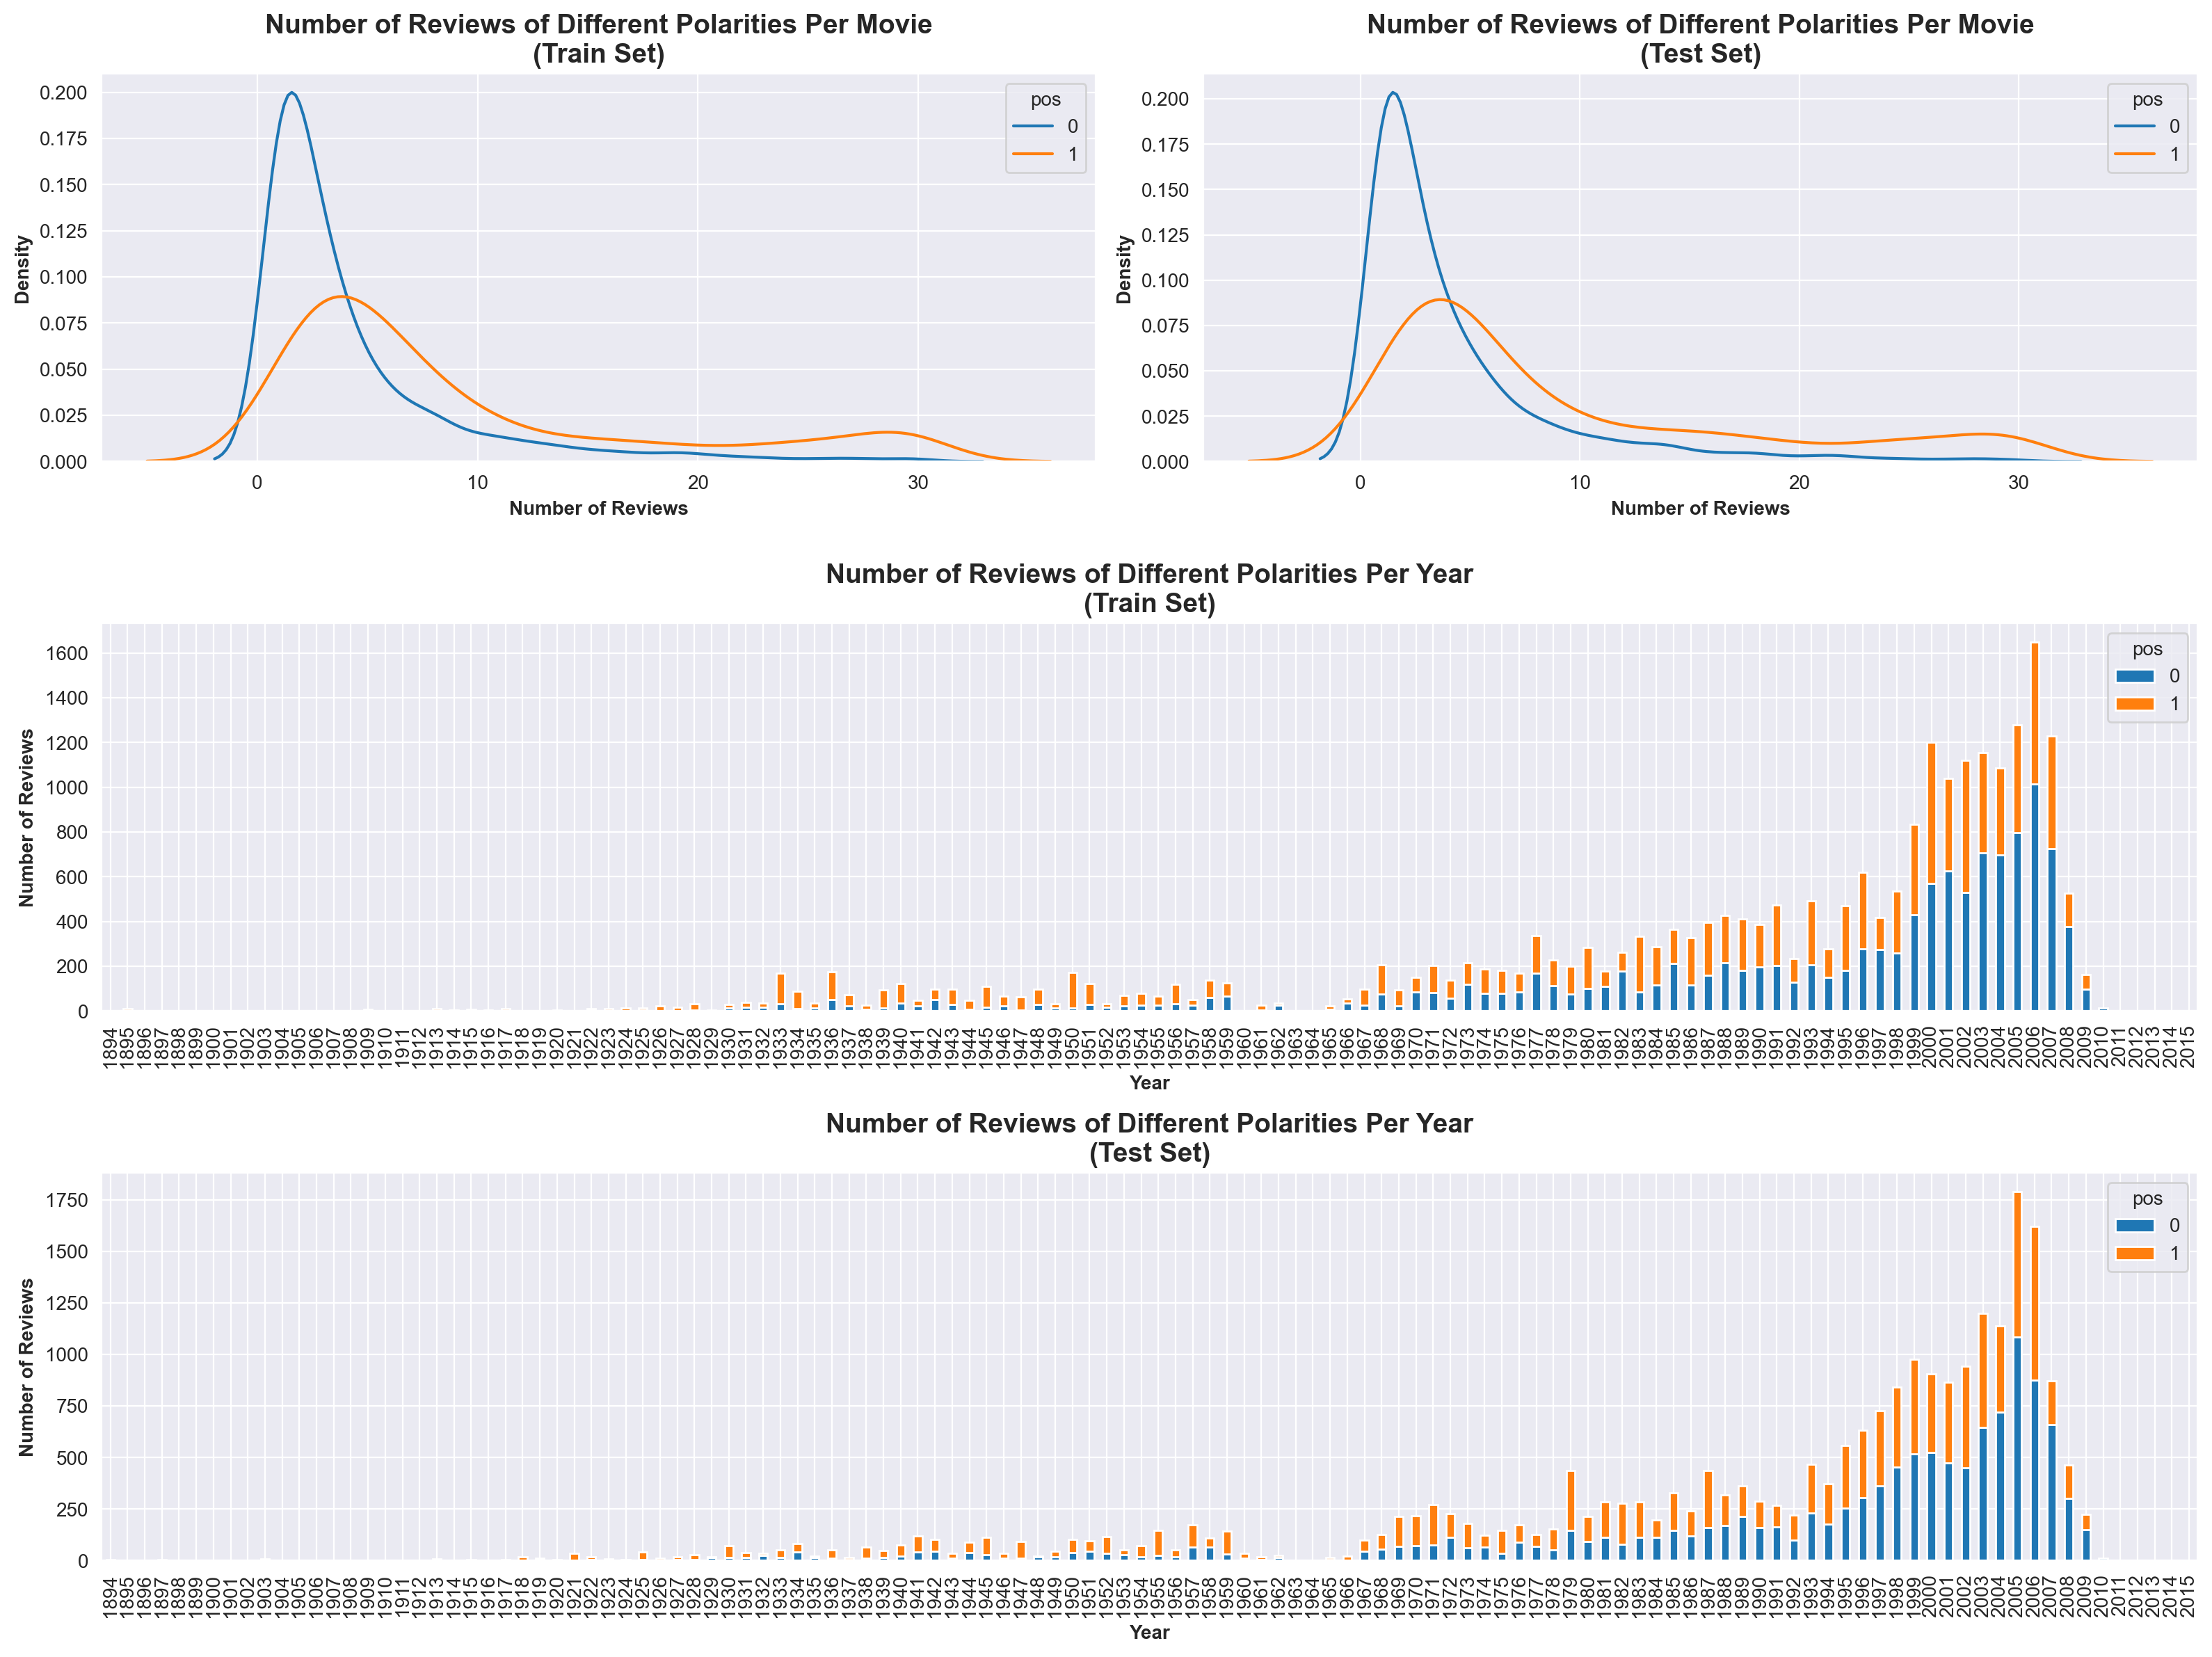

In [21]:
# Plot the distributions of number of reviews in train and test sets
sns.set_style('darkgrid')

layout = '''
    ab
    cc
    dd
'''

fig, axd = plt.subplot_mosaic(layout, figsize=(16, 12))

ax = axd['a']
sns.kdeplot(df_t1['train'][0], ax=ax, label=0)
sns.kdeplot(df_t1['train'][1], ax=ax, label=1)
ax.set_title('Number of Reviews of Different Polarities Per Movie\n(Train Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Reviews', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.legend(title='pos')

ax = axd['b']
sns.kdeplot(df_t1['test'][0], ax=ax, label=0)
sns.kdeplot(df_t1['test'][1], ax=ax, label=1)
ax.set_title('Number of Reviews of Different Polarities Per Movie\n(Test Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Reviews', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.legend(title='pos')

ax = axd['c']
df_t2['train'].plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Number of Reviews of Different Polarities Per Year\n(Train Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Number of Reviews', fontweight='bold')

ax = axd['d']
df_t2['test'].plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Number of Reviews of Different Polarities Per Year\n(Test Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Number of Reviews', fontweight='bold')

fig.tight_layout()
plt.show()

The distributions of number of reviews per movie and per year for both the train and test sets are also similar. The similar distributions in the train and test sets are crucial for creating an effective machine learning model.

[Back to Contents](#back)

### 3.6 Distribution of Target Classes <a id='class_dist'></a>

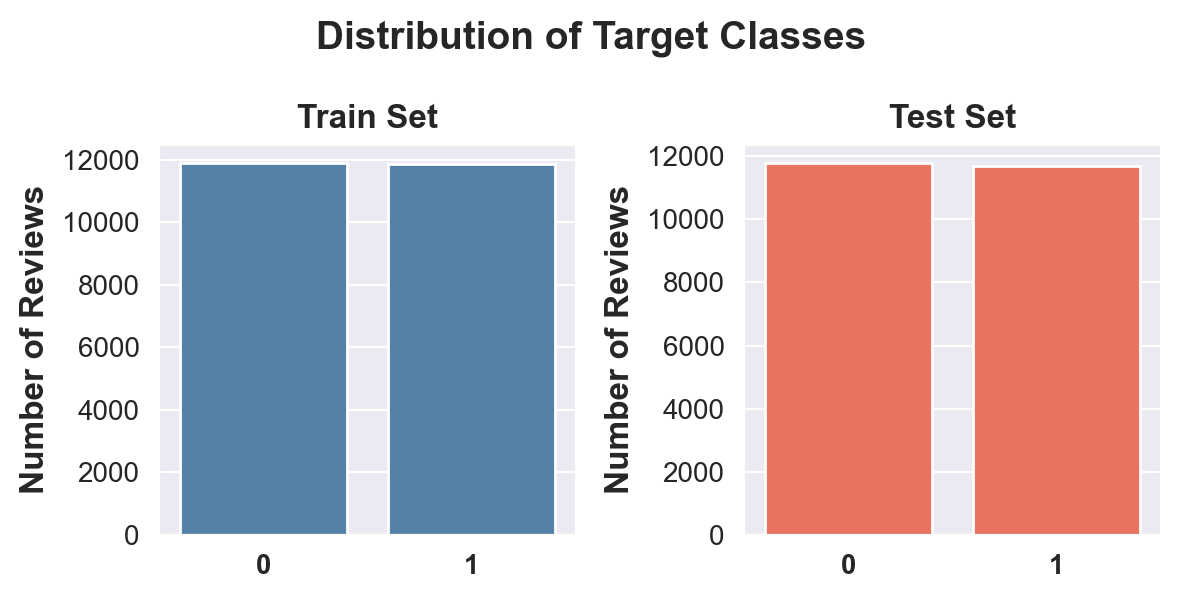

In [22]:
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

fig.suptitle('Distribution of Target Classes', fontsize=14, fontweight='bold')

ax = axs[0]
sns.countplot(data=data.query('ds_part == "train"'), x='pos', color='steelblue', ax=ax)
ax.set_title('Train Set', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Reviews', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_xticks(axs[0].get_xticks())
ax.set_xticklabels(axs[0].get_xticklabels(), fontweight='bold')

ax = axs[1]
sns.countplot(data=data.query('ds_part == "test"'), x='pos', color='tomato', ax=ax)
ax.set_title('Test Set', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Reviews', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_xticks(axs[0].get_xticks())
ax.set_xticklabels(axs[0].get_xticklabels(), fontweight='bold')

fig.tight_layout()
plt.show()

The dataset has no issue of imbalanced classes.

[Back to Contents](#back)

## 4. Modeling <a id='modeling'></a>

Composing an evaluation routine which can be used for all models in this project.

In [23]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    '''
    Evaluate the performance of a binary classification model.

    Evaluate the model performance on the training and test sets.
    Display the scores including f1, accuracy, average precision and ROC-AUC.
    Generate three plots: F1 score curve, ROC curve and PR curve.
    
    Parameters:
    -----------
    model : object
        The trained binary classification model (sklearn or keras).
    X_train : array-like of shape (n_samples, n_features)
        Features of the training set.
    y_train : array-like of shape (n_samples,)
        Labels of the training set.
    X_test : array-like of shape (n_samples, n_features)
        Features of the test set.
    y_test : array-like of shape (n_samples,)
        Labels of the test set.

    Returns:
    --------
    dict
        Dictionary containing evaluation results:
        - 'train_f1' (float): F1 score on the training set.
        - 'test_f1' (float): F1 score on the test set.
        - 'prediction_time (ms)' (int): Prediction time on the test set in milliseconds.

    Examples:
    ---------
    >>> from sklearn.linear_model import LogisticRegression
    >>> from sklearn.model_selection import train_test_split
    >>> model = LogisticRegression()
    >>> # Assume X, y are defined
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    >>> evaluation_results = evaluate_model(model, X_train, y_train, X_test, y_test)
    >>> print(evaluation_results)
    {'train_f1': 0.9, 'test_f1': 0.85, 'prediction_time_ms': 15}
    '''    
    # Create a dictionary to store the evaluation stats to be shown
    eval_stats = {} 
    print('Evaluating the model...')

    # Plot the f1, roc and pr curves
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for data_type, X, y in (('train', X_train, y_train), ('test', X_test, y_test)):

        # Store the train and test stats
        eval_stats[data_type] = {}        

        # Get the predict probability and predictions
        if 'sklearn' in str(type(model)):
            pred_proba = model.predict_proba(X)[:, 1]            
            pred_start = time.time()
            y_pred = model.predict(X)
            pred_end = time.time()
        elif 'keras' in str(type(model)):                       
            pred_start = time.time()
            pred_proba = tf.sigmoid(model.predict(X, verbose=0))
            y_pred = tf.round(pred_proba)
            pred_end = time.time()

        # Store the prediction time on the test set
        if data_type == 'test':
            pred_time = round((pred_end - pred_start) * 1000)

        # Get the required data to plot the f1 curve
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(y, pred_proba>=threshold) for threshold in f1_thresholds]

        fpr, tpr, roc_thresholds = metrics.roc_curve(y, pred_proba)
        roc_auc = metrics.roc_auc_score(y, pred_proba)
        eval_stats[data_type]['ROC AUC'] = roc_auc

        # Get the required data to plot the pr curve
        precision, recall, pr_thresholds = metrics.precision_recall_curve(y, pred_proba)
        aps = metrics.average_precision_score(y, pred_proba)
        eval_stats[data_type]['APS'] = aps

        # Assign colors for train and test sets in graphs
        if data_type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 curve
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{data_type}, max={f1_scores[max_f1_score_idx]:.4f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold', fontsize=12, fontweight='bold')
        ax.set_ylabel('F1', fontsize=12, fontweight='bold')
        ax.legend(loc='lower center', fontsize=14)
        ax.set_title('F1 Score', fontsize=14, fontweight='bold')

        # ROC curve
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{data_type}, ROC AUC={roc_auc:.4f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR', fontsize=12, fontweight='bold')
        ax.set_ylabel('TPR', fontsize=12, fontweight='bold')
        ax.legend(loc='lower center', fontsize=14)
        ax.set_title('ROC Curve', fontsize=14, fontweight='bold')

        # PR curve
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{data_type}, AP={aps:.4f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            axs[2].plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
        ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
        ax.legend(loc='lower center', fontsize=14)
        ax.set_title('PR Curve', fontsize=14, fontweight='bold')

        # Store the accuracy and f1 score
        eval_stats[data_type]['Accuracy'] = metrics.accuracy_score(y, y_pred)
        eval_stats[data_type]['F1'] = metrics.f1_score(y, y_pred)

    # Show the evaluation result
    eval_stats_df = pd.DataFrame(eval_stats)
    eval_stats_df = eval_stats_df.round(4)
    eval_stats_df = eval_stats_df.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    display(eval_stats_df)

    # Store the result to be returned
    result = {        
        'train_f1': eval_stats_df.loc['F1', 'train'],
        'test_f1': eval_stats_df.loc['F1', 'test'],        
        'prediction_time (ms)': pred_time
    }
    
    return result

---

### 4.1 Text Normalisation <a id='text_normalisation'></a>

We assume that all models below accept texts in lowercase without any digit or punctuation mark (except `'`).

In [24]:
# Normalise the review column
data['review_norm'] = data['review'].progress_apply(lambda x: ' '.join(re.sub(r"[^a-zA-Z']", ' ', x).lower().split()))

  0%|          | 0/47240 [00:00<?, ?it/s]

In [25]:
# Check the review before and after normalisation
print('Original reviews:')
display(data['review'].head())
print('\nReviews after normalisation:')
display(data['review_norm'].head())

Original reviews:


0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
2    There is no real story the film seems more lik...
3    Um .... a serious film about troubled teens in...
4    I'm totally agree with GarryJohal from Singapo...
Name: review, dtype: object


Reviews after normalisation:


0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

### 4.2 Train / Test Split <a id='train_test_split'></a>

In [26]:
# Split the dataset into train and test sets according to the ds_part column
X_train = data.query('ds_part == "train"')['review_norm']
y_train = data.query('ds_part == "train"')['pos'].astype('float')
X_test = data.query('ds_part == "test"')['review_norm']
y_test = data.query('ds_part == "test"')['pos'].astype('float')

# Check the shapes
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (23757,)
Shape of y_train: (23757,)
Shape of X_test: (23483,)
Shape of y_test: (23483,)


[Back to Contents](#back)

### 4.3 Model Development and Evaluation <a id='model_dev_eval'></a>

In this section the normalised texts will be further preprocessed with four different methods, which are `nltk\bag-of-words`, `nltk/tf-idf`, `spacy/tf-idf` and `BERT`. For each method, two models namely logistic regression and lightgbm will be developed and evaluated. Besides that, an additional neural network classifier will also be developed for the `BERT` method.

The following hyperparameters will be tuned for the above models:

1. Logistic Regression
- `C`: The cost of misclassifying labels and it is the inverse of the regularisation strength. The larger the `C`, the more complex the model is and can possibly lead to overfitting.

2. LightGBM
- `max_depth`: The maximum depth of a single tree. If the value is too low, the model might not be able to generalise well. However, a high value might cause overfitting of the model.
- `n_estimators`: The total number of trees. This number should be large enough to reduce the variance and prevent model from being overfitting. However, it will be computational expensive for a large number of trees. To improve the training speed, we can try a lower number of `n_estimators` with a higher number of `max_depth`.
- `num_leaves`: The complexity of the model increases with the number of leaves. Therefore, a high number of leaves may lead to overfitting.
- `learning_rate`: This parameter decides the step size of the gradient descent in the optimisaton process. A small value may not find the optimised value if the number of trees is not large enough. A large value speeds up the training speed but may overshoot the optimised value.
- `reg_alpha`: The L1 regularisation which penalise large weights on the features and thus prevent overfitting. L1 regularisation encourages the sparsity in the features (the weight can be zero)
- `reg_lambda`: The L2 regularisation. This L2 regularisation is similar to the L1 regularisation but does not enforce sparsity.
- `subsample`: The fraction of rows used in the tree and is used to prevent overfitting. A Low value can improve the training speed but also affect the model's ability to generalise to unseen data.
- `colsample_bytree`: The fraction of features used in the tree. Similar to `subsample`, this hyperparameter can prevent overfitting by introduced additional randomness.

3. Neural Network:
- `units`: The number of hidden units in the each hidden layer. The more the `units`, the more complex the model is and can possibly lead to overfitting.
- `hidden_layers`: The number of layers between the input layer and output layer. The more the `hidden_layers`, the more complex the model is and can possibly lead to overfitting.
- `learning_rate`: Similar to the LightGBM, this parameter decides the step size of the gradient descent in the optimisaton process.
- `epochs`: An epoch is one complete pass through the entire training dataset in the training step. 

Together with a constant model, a total of ten models will be built.


***Feel free to skip the optimisation process. The optimised models have been saved.***

**Model 0 - Constant**

In [27]:
# Dicts to store various information for later use
result = {}
best_model = {}
train_time = {}

In [28]:
# Set up for the modeling process
model_name = 'constant'
opt_model = DummyClassifier
train_features = X_train
test_features = X_test
n_trials = 1

In [29]:
# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {}

    # Train and evaluate the model
    model = opt_model(**hyperparameters)    
    cv_f1 = cross_val_score(model, train_features, y_train, scoring='f1', cv=3).mean()
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = sklearn_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising constant... :   0%|          | 0/1 [00:00<?, ?it/s]

Best hyperparameters:


{}

In [30]:
# Create a folder to store the model
model_folder = Path('models')
model_folder.mkdir(parents='True', exist_ok=True)

The constant model has been saved.

Evaluating the model...


train    test
Accuracy  0.5007  0.5019
F1        0.0000  0.0000
APS       0.4993  0.4981
ROC AUC   0.5000  0.5000

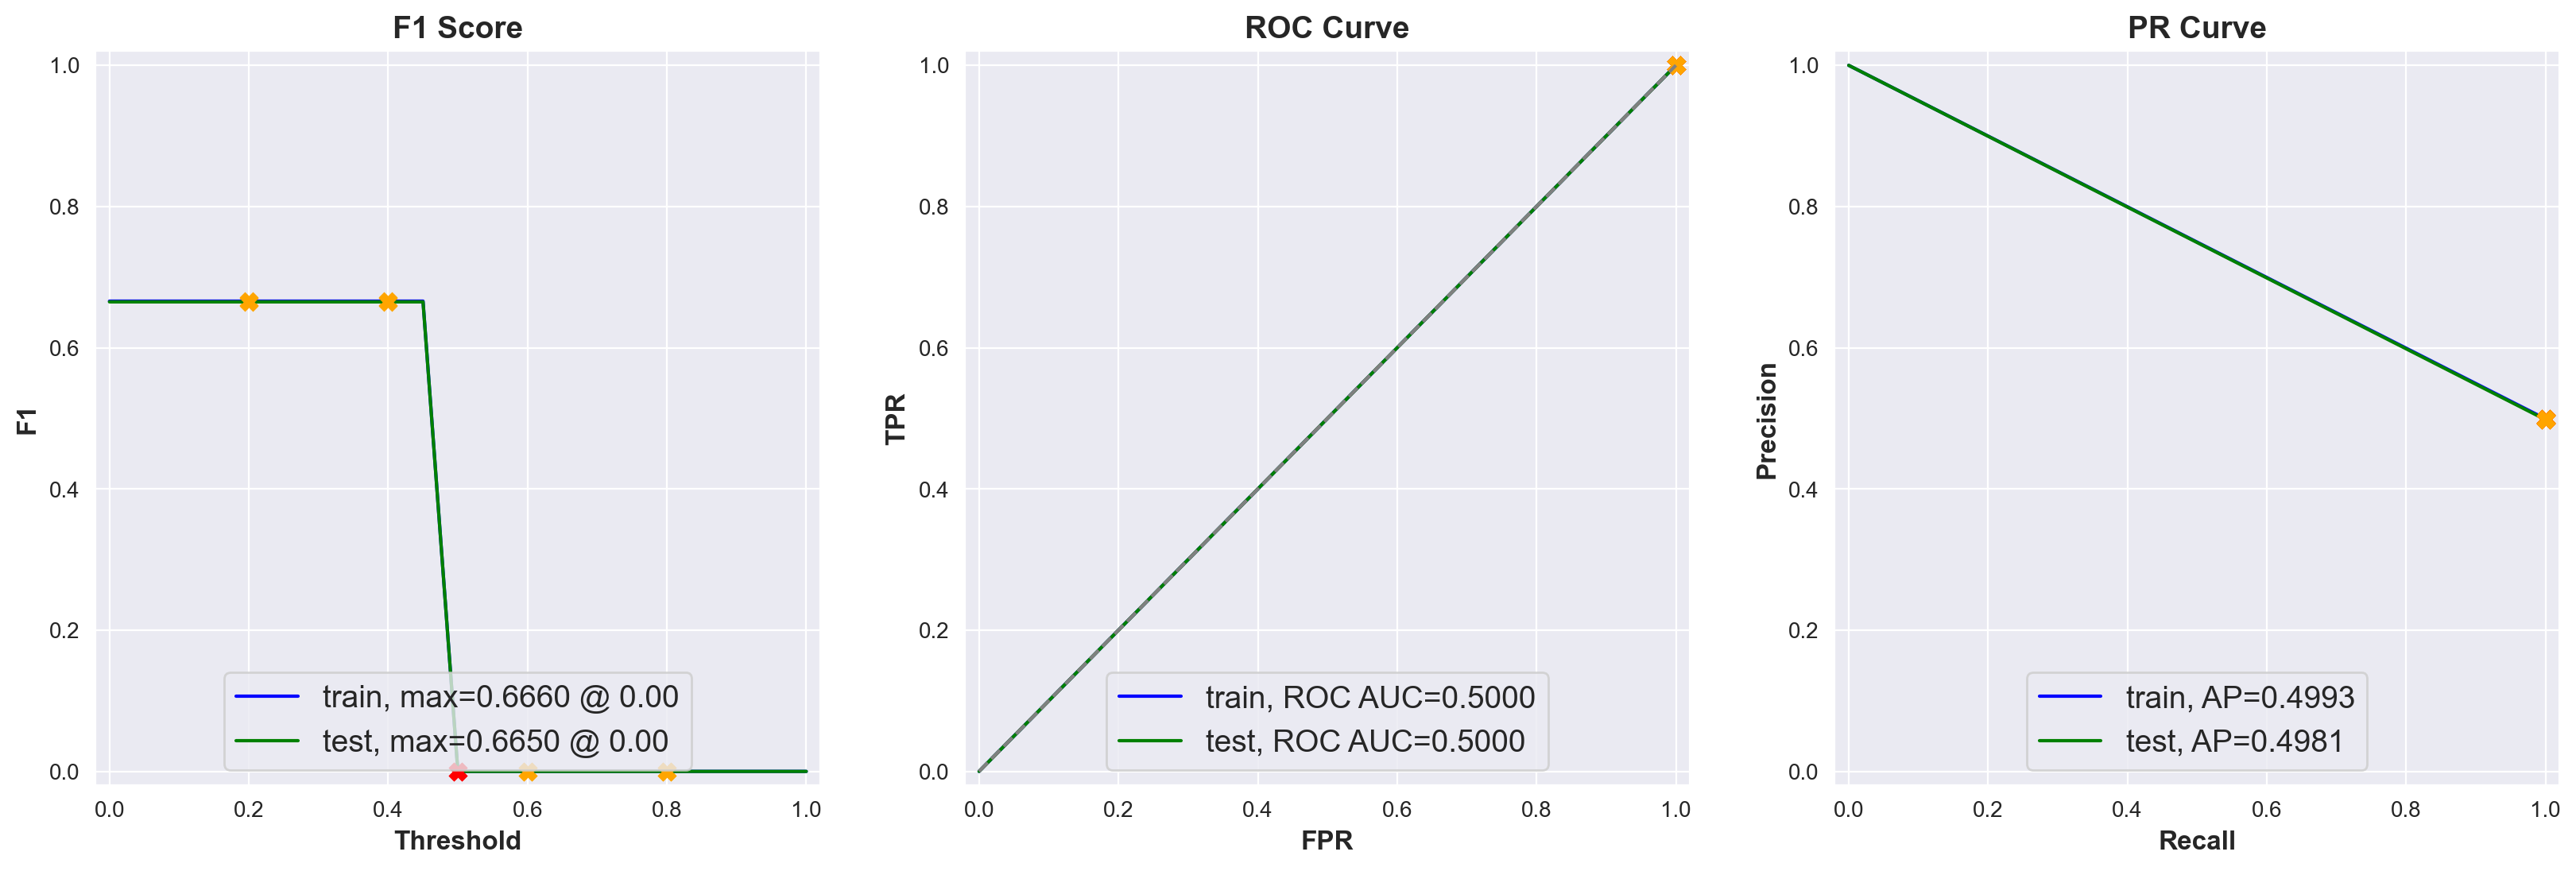

In [31]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')      
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

In [32]:
# Check the majority class in train and test set
print('Majority class in train set:', y_train.value_counts().idxmax())
print('Majority class in test set:', y_test.value_counts().idxmax())

Majority class in train set: 0.0
Majority class in test set: 0.0


**Since the constant model always predict `0` (the majority class of train set) and the number of true positive is always 0, thus the f1-scores for both the train and test sets are 0.**

### 4.3.1 NLTK / Bag-of-Words <a id='nltk_bow'></a>

In [33]:
# Create a function to preprocess text with nltk
def nltk_text_preprocessing(text):
    '''Process the text with the NLTK library'''
    tokens = word_tokenize(text)
    lemmas = [WordNetLemmatizer().lemmatize(token) for token in tokens]

    return ' '.join(lemmas)

In [34]:
# Preprocessing features with nltk
print('Preprocessing train features with nltk...')
X_train_nltk = X_train.progress_apply(nltk_text_preprocessing)
print('Preprocessing test features with nltk...')
X_test_nltk = X_test.progress_apply(nltk_text_preprocessing)

Preprocessing train features with nltk...


  0%|          | 0/23757 [00:00<?, ?it/s]

Preprocessing test features with nltk...


  0%|          | 0/23483 [00:00<?, ?it/s]

In [35]:
%%time
# Use bag-of-words model to preprocess features
nltk_count_vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X_train_nltk_bow = nltk_count_vectorizer.fit_transform(X_train_nltk).astype('float')
X_test_nltk_bow = nltk_count_vectorizer.transform(X_test_nltk).astype('float')

# Find the number of features created
print('Number of features created with nltk and bag-of-words model:', X_train_nltk_bow.shape[1])

Number of features created with nltk and bag-of-words model: 64297
CPU times: total: 6.44 s
Wall time: 6.46 s


**Model 1 - NLTK, Bag-of-Words and Logistic Regression**

In [36]:
# Set up for the modeling process
model_name = 'nltk_bow_lr'
opt_model = LogisticRegression
train_features = X_train_nltk_bow
test_features = X_test_nltk_bow
n_trials = 30

In [37]:
# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {
        'max_iter': trial.suggest_int('max_iter', 350, 350), # for the algorithm to converge
        'C': trial.suggest_float('C', 1e-3, 1e0, log=True)
    }

    # Train and evaluate the model
    model = opt_model(**hyperparameters)    
    cv_f1 = cross_val_score(model, train_features, y_train, scoring='f1', cv=3).mean()
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = sklearn_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising nltk_bow_lr... :   0%|          | 0/30 [00:00<?, ?it/s]

Best hyperparameters:


{'max_iter': 350, 'C': 0.022602281566750995}

The nltk_bow_lr model has been saved.

Evaluating the model...


train    test
Accuracy  0.9390  0.8791
F1        0.9393  0.8788
APS       0.9840  0.9416
ROC AUC   0.9835  0.9461

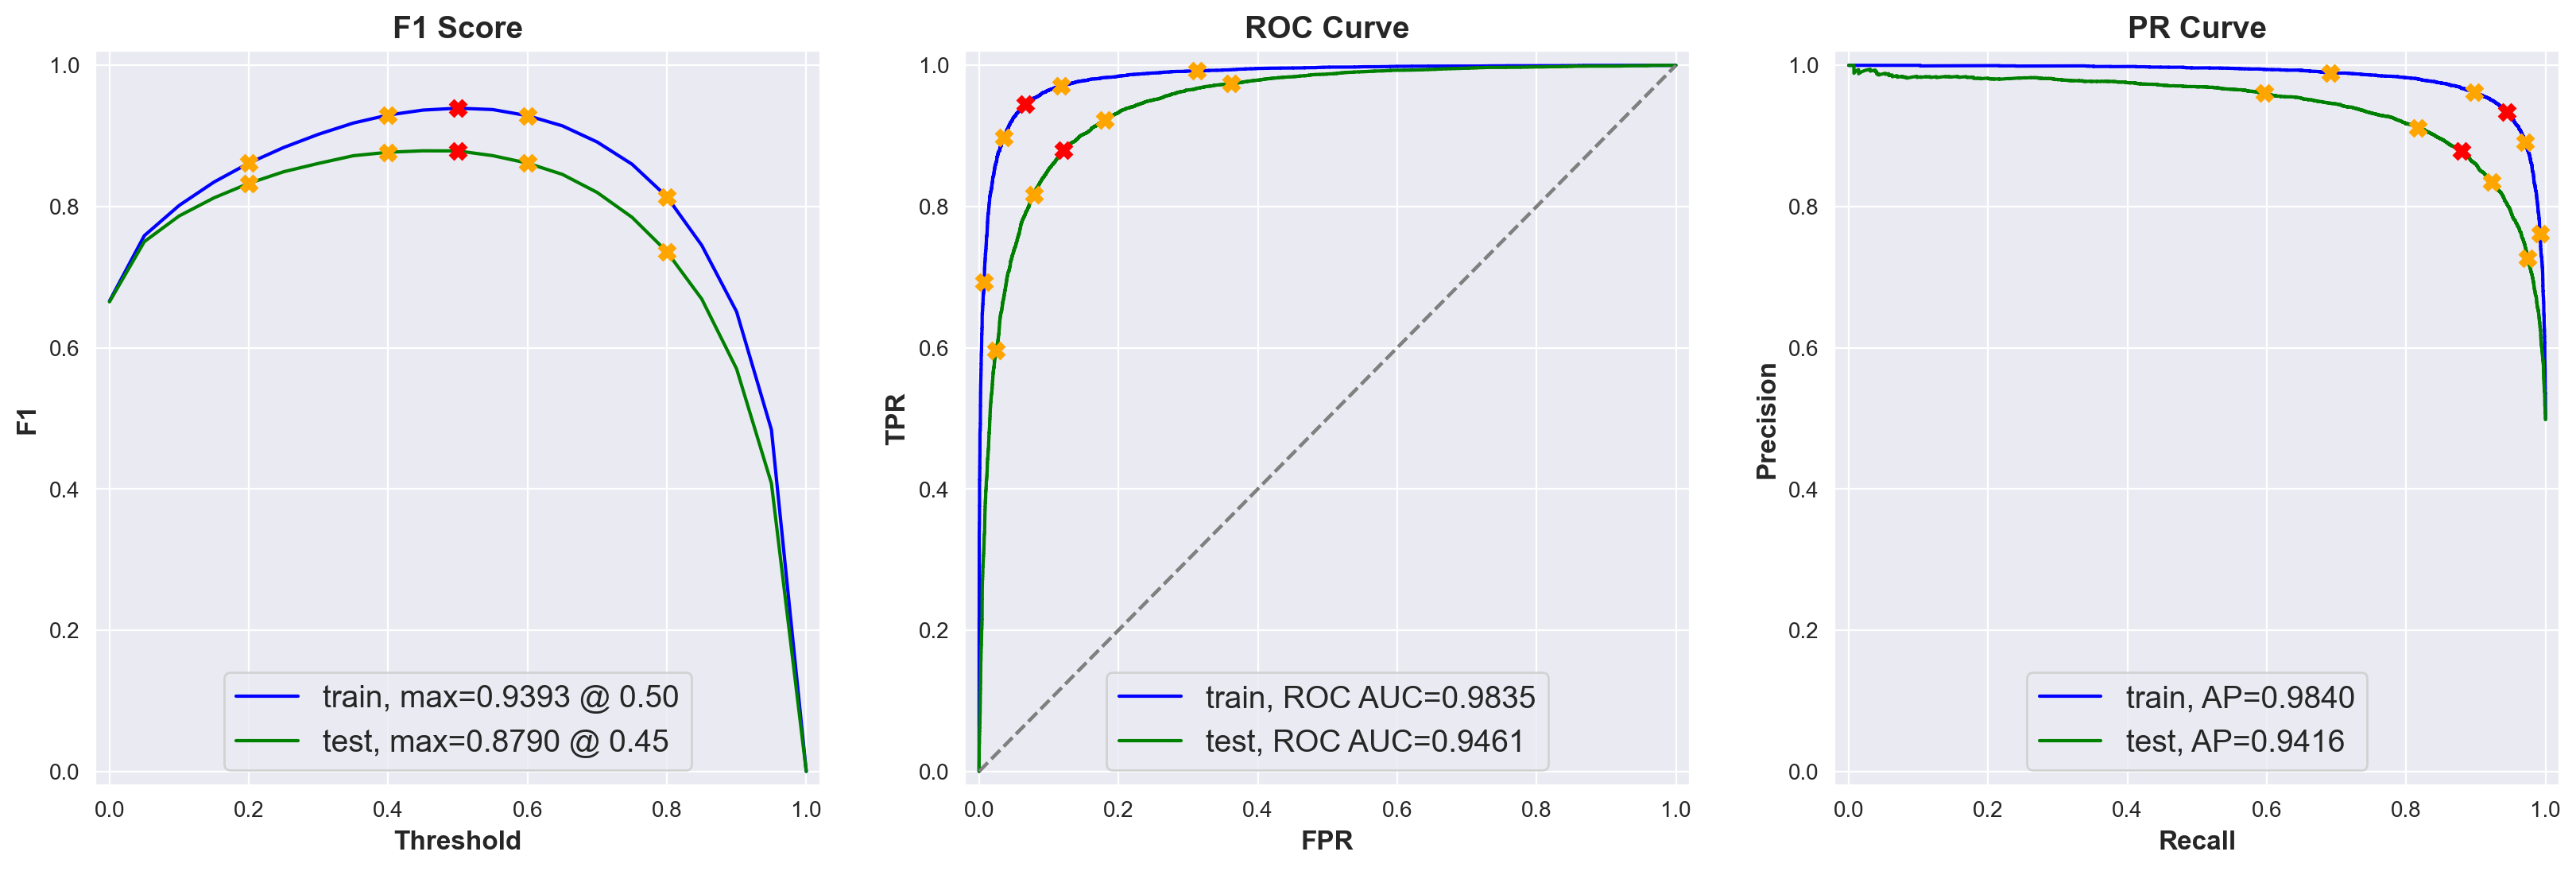

In [38]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')      
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

**With the `nltk/bag-of-words` preprocessing method, the logistic regression performed has a test f1 score of 0.8788 at the threshold of 0.5, the best f1 score is 0.8790 at the threshold of 0.45. The model is overfitted with the training set.**

**Model 2 - NLTK, Bag-of-Words and LightGBM**

In [39]:
# Set up for the modeling process
model_name = 'nltk_bow_lgbm'
opt_model = LGBMClassifier
train_features = X_train_nltk_bow
test_features = X_test_nltk_bow
n_trials = 30

In [40]:
# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters ={
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),
        'verbose': trial.suggest_int('verbose', -1, -1)
    }

    # Train and evaluate the model
    model = opt_model(**hyperparameters)    
    cv_f1 = cross_val_score(model, train_features, y_train, scoring='f1', cv=3).mean()
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = sklearn_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising nltk_bow_lgbm... :   0%|          | 0/30 [00:00<?, ?it/s]

Best hyperparameters:


{'max_depth': 5,
 'n_estimators': 60,
 'num_leaves': 6,
 'learning_rate': 0.5345166110646817,
 'reg_alpha': 0.01967432802530612,
 'reg_lambda': 2.0540519425388455,
 'subsample': 0.5935133228268233,
 'colsample_bytree': 0.6080272084711243,
 'verbose': -1}

The nltk_bow_lgbm model has been saved.

Evaluating the model...


train    test
Accuracy  0.8677  0.8539
F1        0.8702  0.8560
APS       0.9399  0.9268
ROC AUC   0.9420  0.9311

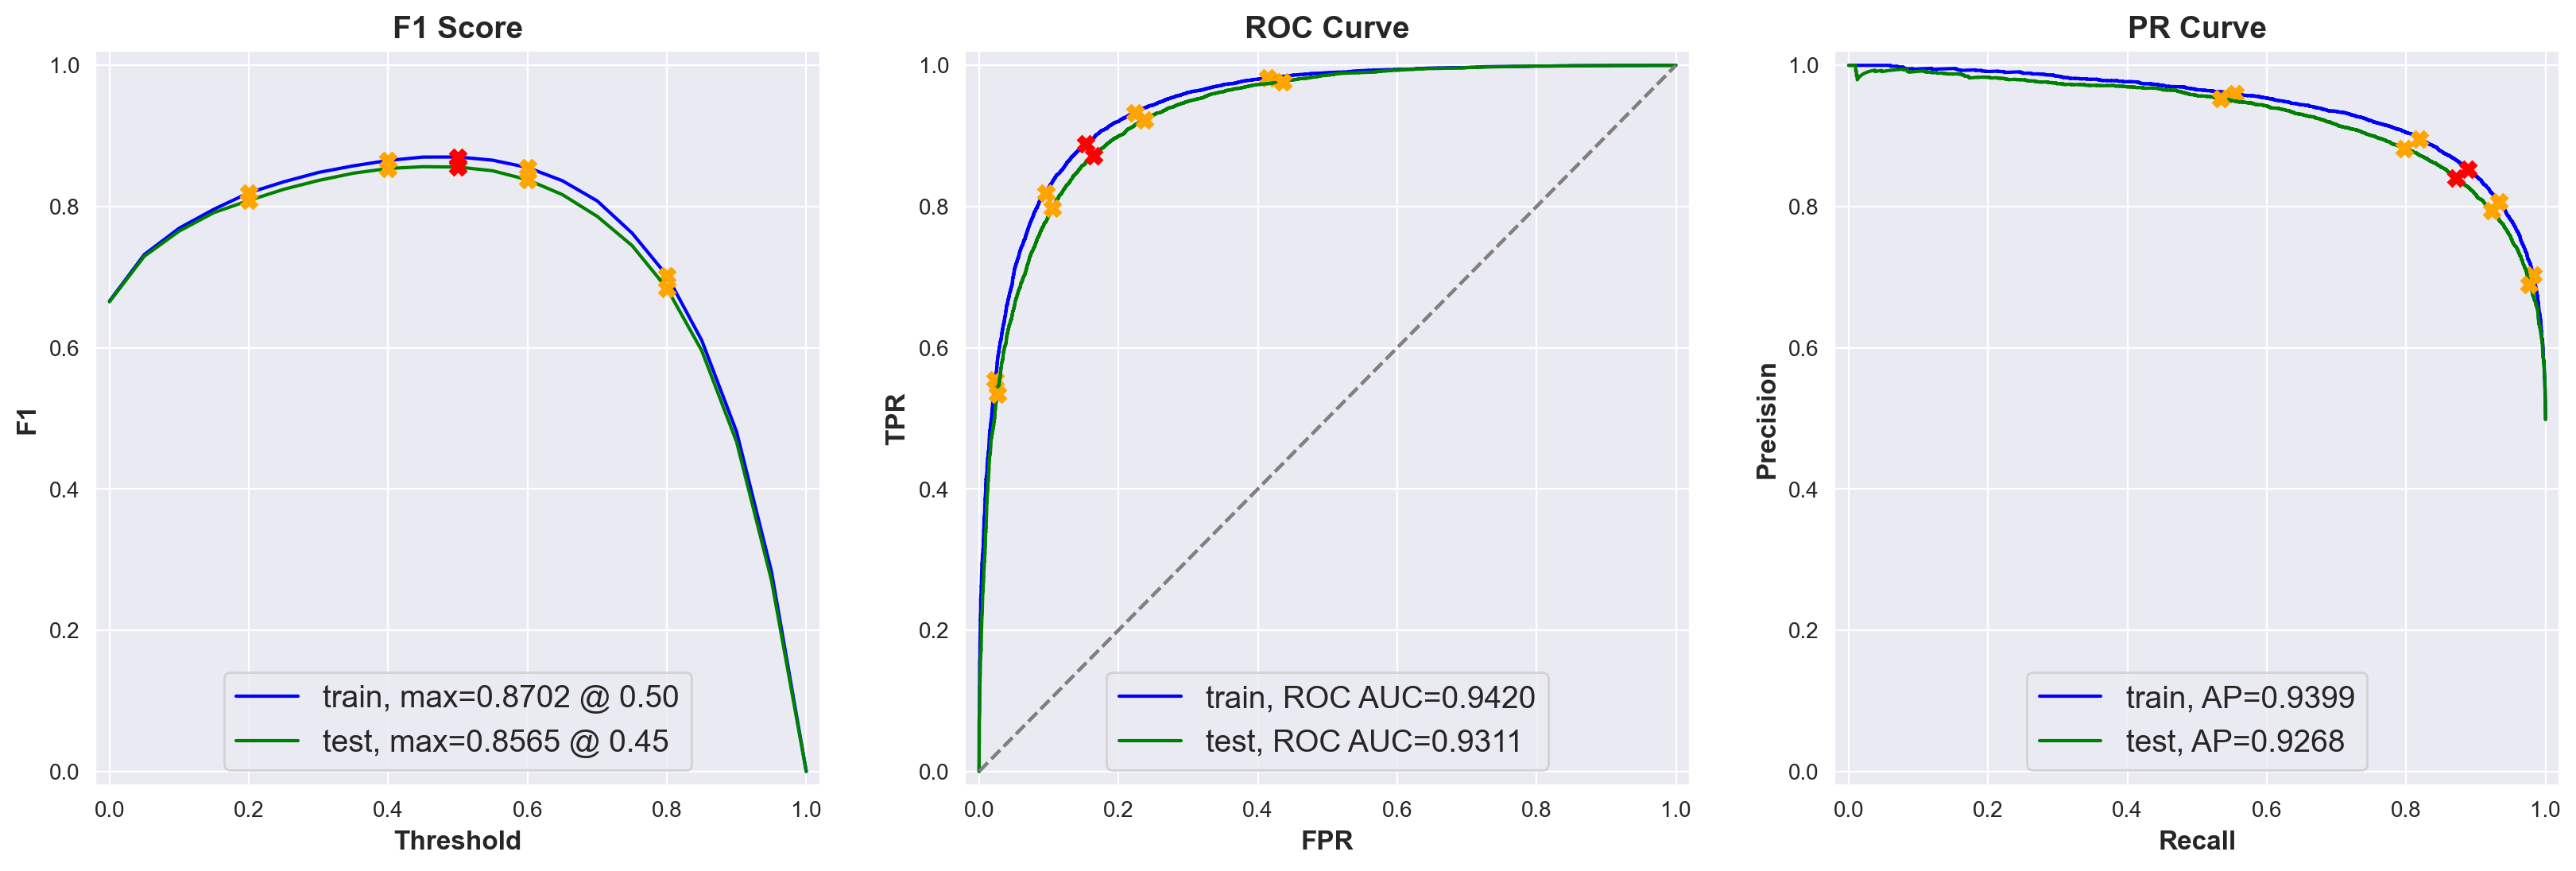

In [41]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')      
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

**For the `nltk/bag-of-words` preprocessing method, the logistic regression model has a better test f1 score of 0.8788 than the lightgbm model and is faster to train. However, the logistic regression model obviously has an overfitting issue.**

[Back to Contents](#back)

### 4.3.2 NLTK / TF-IDF <a id='nltk_tfidf'></a>

In [42]:
%%time
# Use tf-idf model to preprocess features
nltk_tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X_train_nltk_tfidf = nltk_tfidf_vectorizer.fit_transform(X_train_nltk)
X_test_nltk_tfidf = nltk_tfidf_vectorizer.transform(X_test_nltk)

# Find the number of features created
print('Number of features created with nltk and tf-idf model:', X_train_nltk_tfidf.shape[1])

Number of features created with nltk and tf-idf model: 64297
CPU times: total: 5.66 s
Wall time: 5.67 s


**Model 3 - NLTK, TF-IDF and Logistic Regression**

In [43]:
# Set up for the modeling process
model_name = 'nltk_tfidf_lr'
opt_model = LogisticRegression
train_features = X_train_nltk_tfidf
test_features = X_test_nltk_tfidf
n_trials = 30

In [44]:
# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {        
        'C': trial.suggest_float('C', 1e-3, 1e0, log=True)
    }

    # Train and evaluate the model
    model = opt_model(**hyperparameters)    
    cv_f1 = cross_val_score(model, train_features, y_train, scoring='f1', cv=3).mean()
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = sklearn_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising nltk_tfidf_lr... :   0%|          | 0/30 [00:00<?, ?it/s]

Best hyperparameters:


{'C': 0.9945533728214312}

The nltk_tfidf_lr model has been saved.

Evaluating the model...


train    test
Accuracy  0.9354  0.8798
F1        0.9357  0.8792
APS       0.9824  0.9481
ROC AUC   0.9820  0.9507

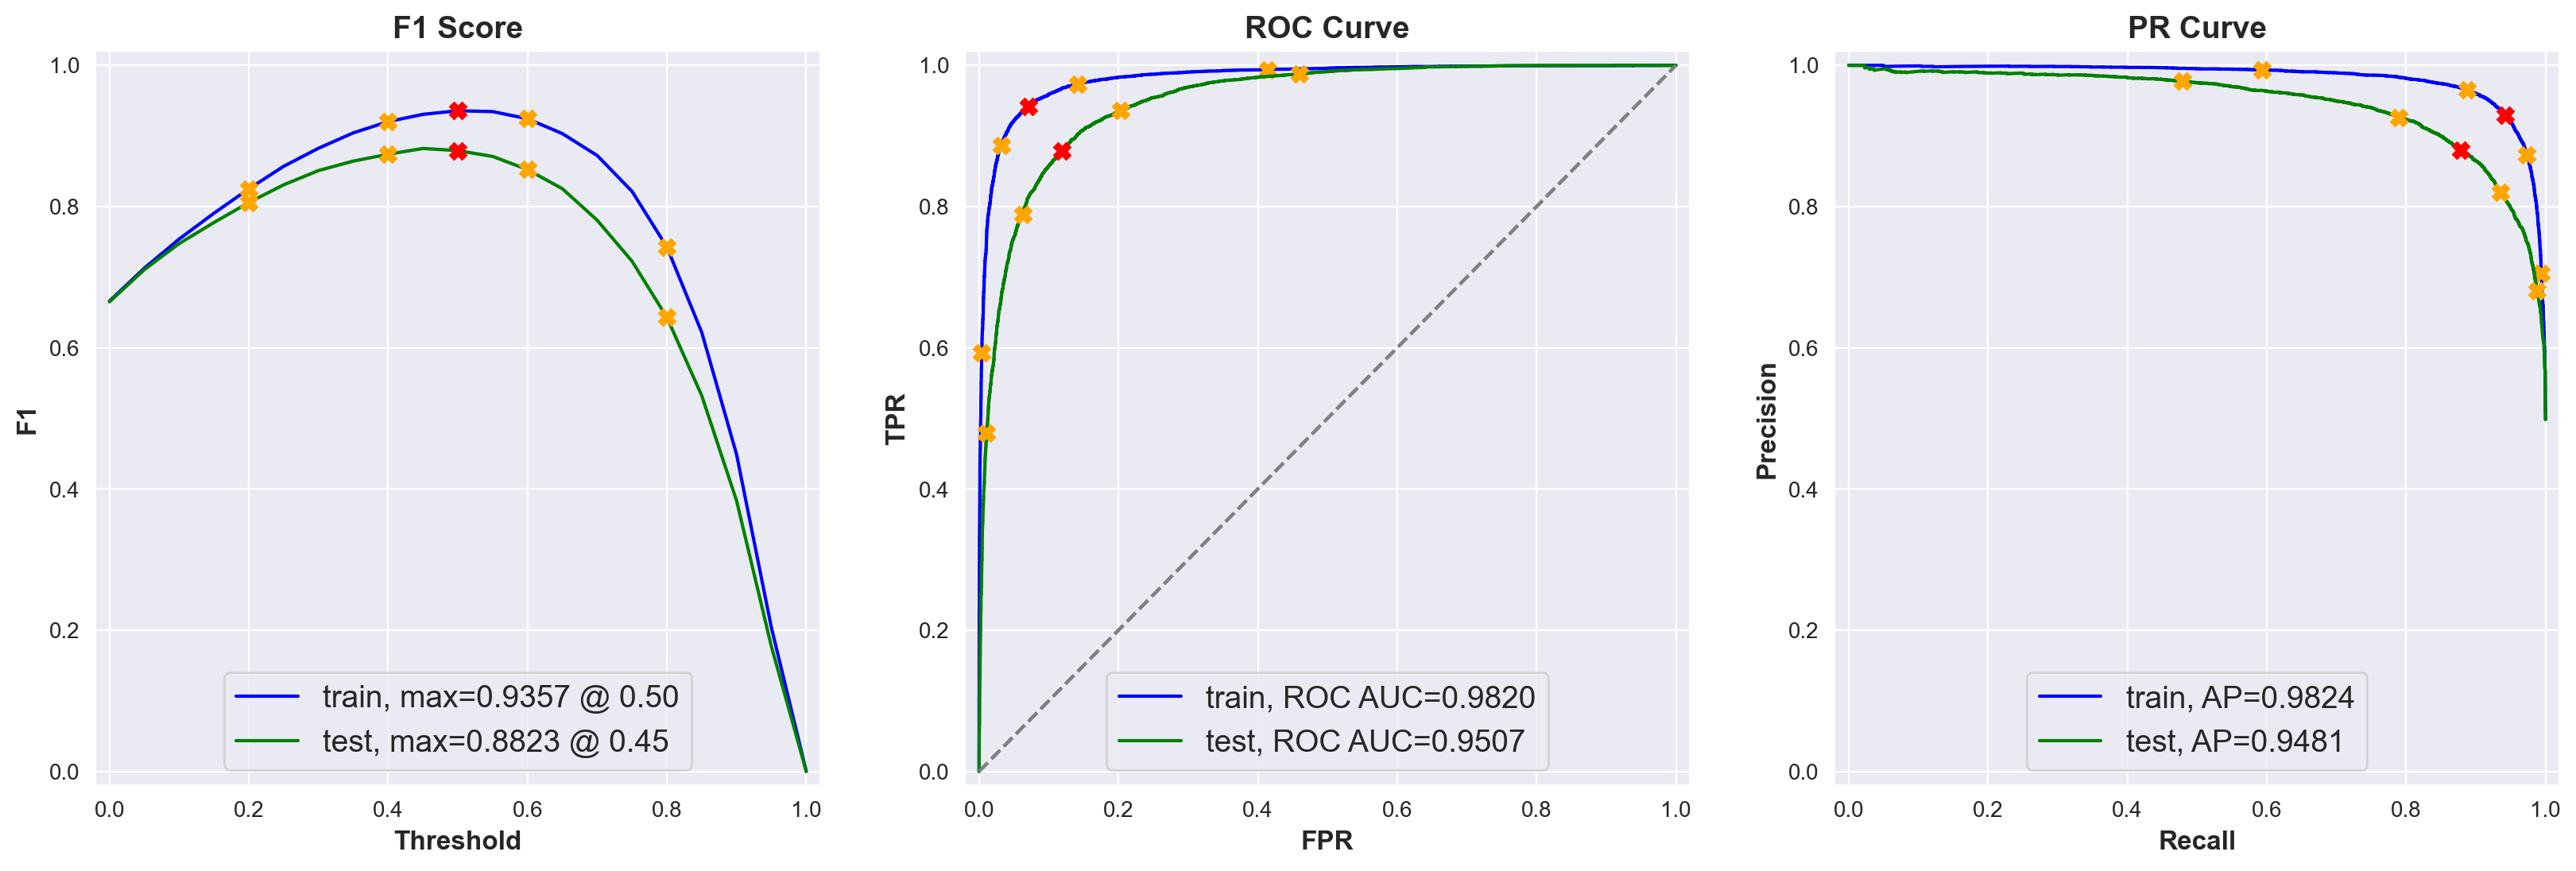

In [45]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:    
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')      
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

**With the `nltk/tfidf` preprocessing method, the logistic regression has a test f1 score of 0.8792. Again, the best f1 score of 0.8823 occurs at the thereshold of 0.45.**

**Model 4 - NLTK, TF-IDF and LightGBM**

In [46]:
# Set up for the modeling process
model_name = 'nltk_tfidf_lgbm'
opt_model = LGBMClassifier
train_features = X_train_nltk_tfidf
test_features = X_test_nltk_tfidf
n_trials = 30

In [47]:
# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters ={
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),
        'verbose': trial.suggest_int('verbose', -1, -1)
    }

    # Train and evaluate the model
    model = opt_model(**hyperparameters)    
    cv_f1 = cross_val_score(model, train_features, y_train, scoring='f1', cv=3).mean()
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = sklearn_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising nltk_tfidf_lgbm... :   0%|          | 0/30 [00:00<?, ?it/s]

Best hyperparameters:


{'max_depth': 11,
 'n_estimators': 65,
 'num_leaves': 11,
 'learning_rate': 0.46377948408023406,
 'reg_alpha': 2.488409026764326,
 'reg_lambda': 1.4793296534955782,
 'subsample': 0.6145998835371946,
 'colsample_bytree': 0.5227603849890128,
 'verbose': -1}

The nltk_tfidf_lgbm model has been saved.

Evaluating the model...


train    test
Accuracy  0.8982  0.8581
F1        0.8993  0.8595
APS       0.9629  0.9326
ROC AUC   0.9637  0.9361

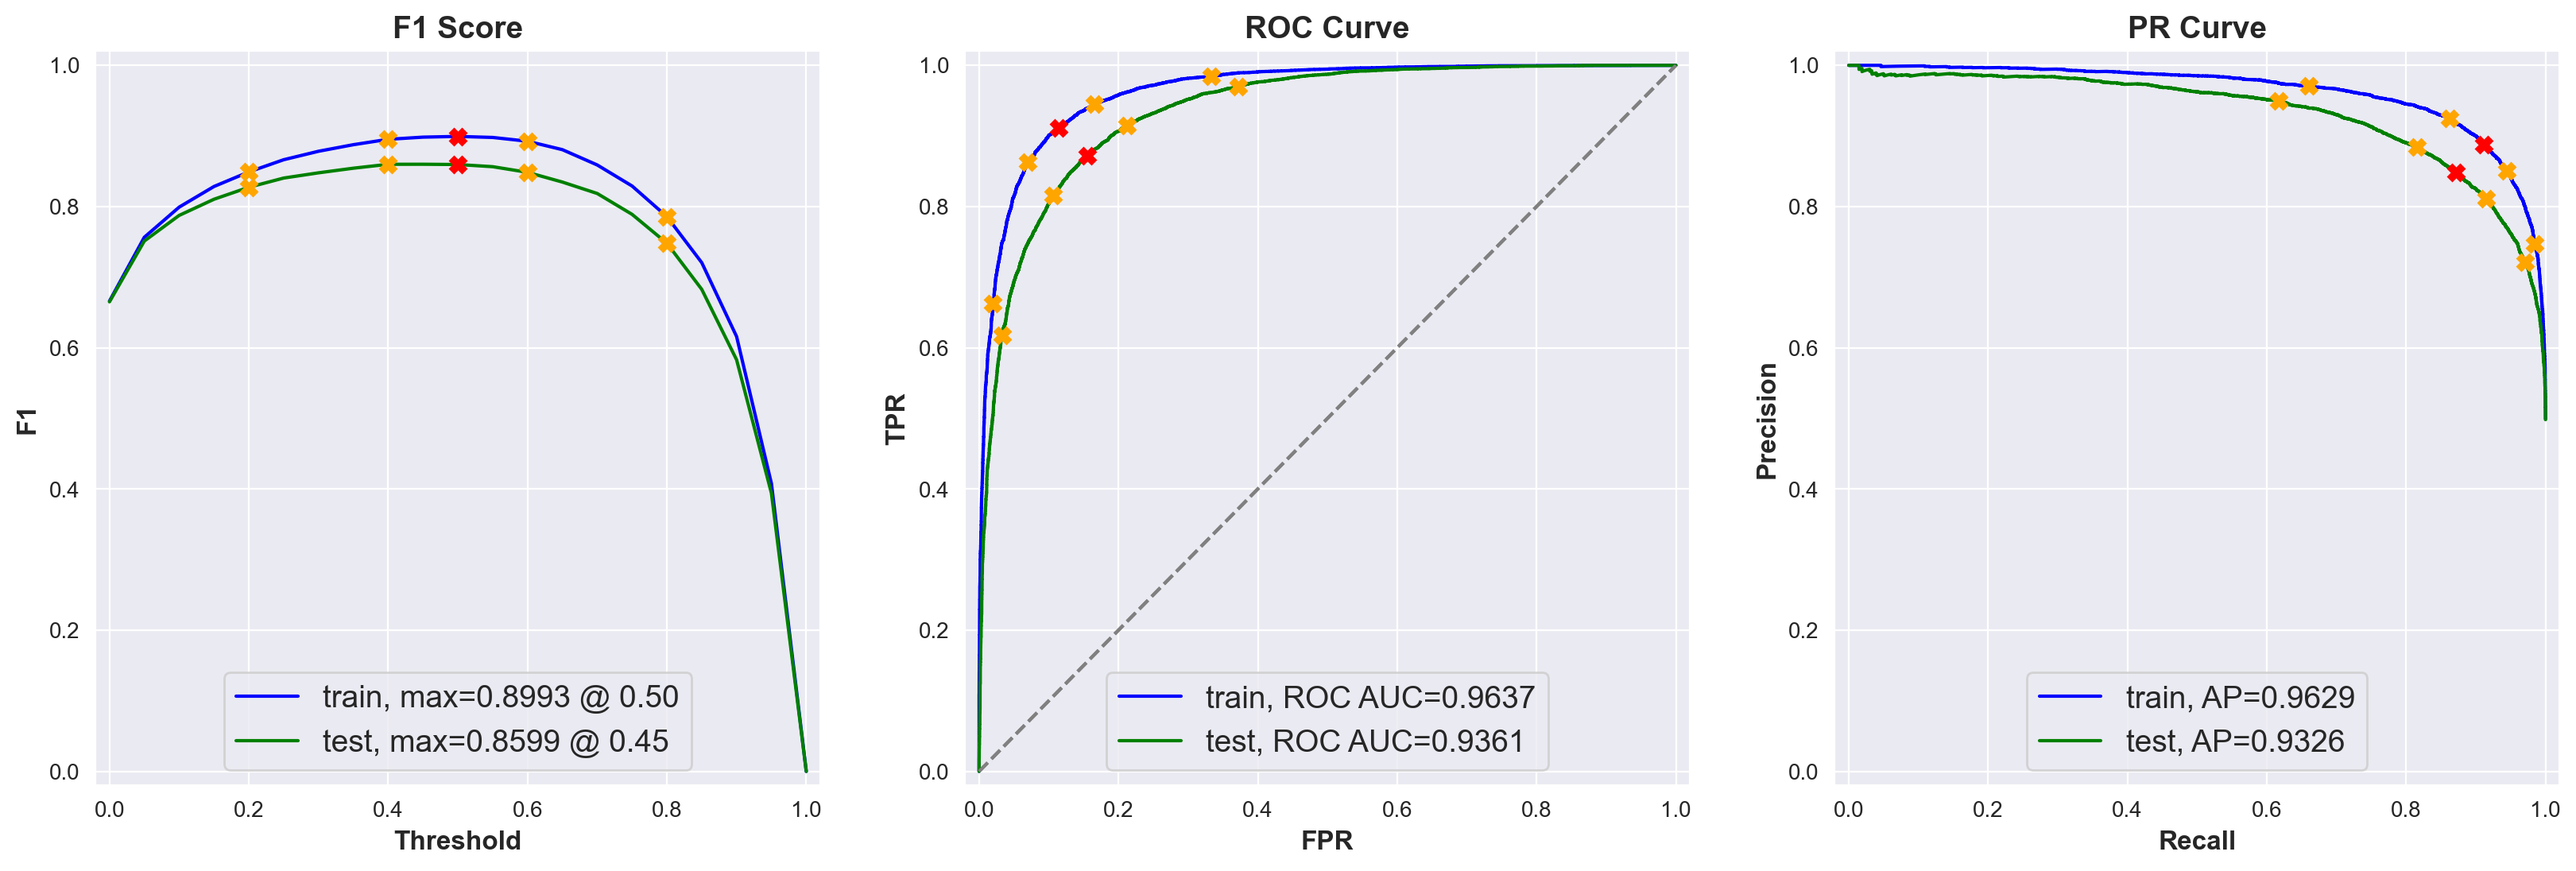

In [48]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')      
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

**For the `nltk/tf-idf` preprocessing method, the logistic regression model outperforms the lightgbm model in terms of f1-scores and training time. Both of the models have overfitting issue. Compared with the logistic regression model with `nltk/bag-of-words`, the logistic regression with `nltk/tf-idf` has a slightly better test f1 score of 0.8792 and is faster to converge.**

[Back to Contents](#back)

### 4.3.3 spaCy / TF-IDF <a id='spacy_tfidf'></a>

In [49]:
# Create a spacy model instance
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [50]:
# Create a function to preprocess text with nltk
def spacy_text_preprocessing(text):
    '''Process the text with the spaCy library'''
    doc = nlp(text)
    # the stopwords class from nltk library provides better result in this project
    # tokens = [token.lemma_ for token in doc if not token.is_stop] 
    tokens = [token.lemma_ for token in doc]                        

    return ' '.join(tokens)

In [51]:
# preprocessing features with spacy
print('Preprocessing train features with spaCy...')
X_train_spacy = X_train.progress_apply(spacy_text_preprocessing)
print('Preprocessing test features with spaCy...')
X_test_spacy = X_test.progress_apply(spacy_text_preprocessing)

Preprocessing train features with spaCy...


  0%|          | 0/23757 [00:00<?, ?it/s]

Preprocessing test features with spaCy...


  0%|          | 0/23483 [00:00<?, ?it/s]

**It took longer time to preprocessing texts with the spaCy model.**

In [52]:
%%time
# Use tf-idf model to preprocess features
spacy_tfidf_vectorizer = TfidfVectorizer()
X_train_spacy_tfidf = spacy_tfidf_vectorizer.fit_transform(X_train_spacy)
X_test_spacy_tfidf = spacy_tfidf_vectorizer.transform(X_test_spacy)

# Find the number of features created
print('Number of features created with spacy and tf-idf model:', X_train_spacy_tfidf.shape[1])

Number of features created with spacy and tf-idf model: 59215
CPU times: total: 7.05 s
Wall time: 7.1 s


**Model 5 - spaCy, TF-IDF and Logistic Regression**

In [53]:
# Set up for the modeling process
model_name = 'spacy_tfidf_lr'
opt_model = LogisticRegression
train_features = X_train_spacy_tfidf
test_features = X_test_spacy_tfidf
n_trials = 30

In [54]:
# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {        
        'C': trial.suggest_float('C', 1e-3, 1e0, log=True)
    }

    # Train and evaluate the model
    model = opt_model(**hyperparameters)    
    cv_f1 = cross_val_score(model, train_features, y_train, scoring='f1', cv=3).mean()
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = sklearn_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising spacy_tfidf_lr... :   0%|          | 0/30 [00:00<?, ?it/s]

Best hyperparameters:


{'C': 0.9844498380225956}

The spacy_tfidf_lr model has been saved.

Evaluating the model...


train    test
Accuracy  0.9257  0.8810
F1        0.9262  0.8806
APS       0.9784  0.9481
ROC AUC   0.9775  0.9501

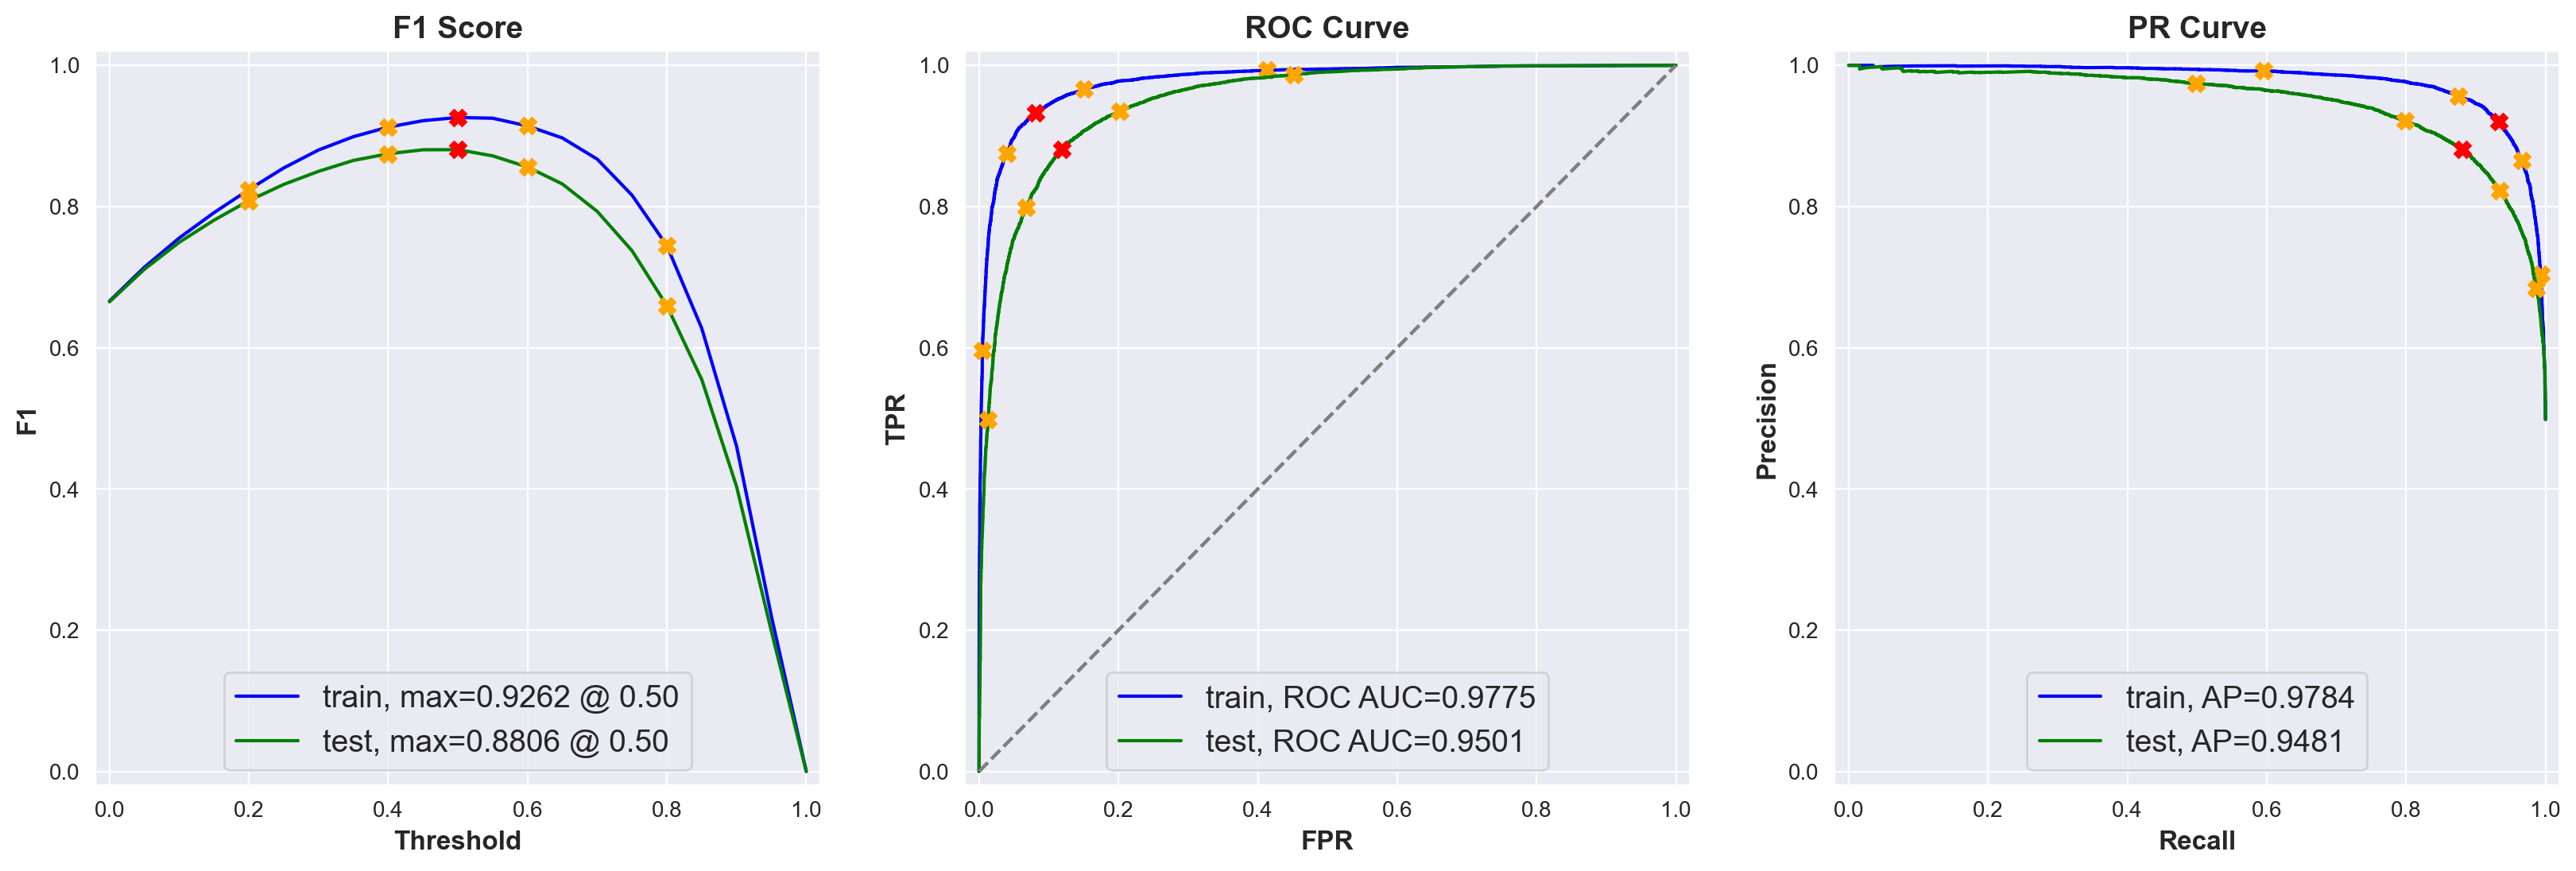

In [55]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')      
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

**With the `spaCy/tfidf` preprocessing method, the logistic regression model achieves the best test f1 score of 0.8806 at the threshold of 0.5. The model exhibits a lesser degree of overfitting compared to the previous two logistic regression models.**

**Model 6 - spaCy, TF-IDF and LightGBM**

In [56]:
# Set up for the modeling process
model_name = 'spacy_tfidf_lgbm'
opt_model = LGBMClassifier
train_features = X_train_spacy_tfidf
test_features = X_test_spacy_tfidf
n_trials = 30

In [57]:
# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters ={
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),
        'verbose': trial.suggest_int('verbose', -1, -1)
    }

    # Train and evaluate the model
    model = opt_model(**hyperparameters)    
    cv_f1 = cross_val_score(model, train_features, y_train, scoring='f1', cv=3).mean()
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = sklearn_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising spacy_tfidf_lgbm... :   0%|          | 0/30 [00:00<?, ?it/s]

Best hyperparameters:


{'max_depth': 5,
 'n_estimators': 60,
 'num_leaves': 6,
 'learning_rate': 0.5345166110646817,
 'reg_alpha': 0.01967432802530612,
 'reg_lambda': 2.0540519425388455,
 'subsample': 0.5935133228268233,
 'colsample_bytree': 0.6080272084711243,
 'verbose': -1}

The spacy_tfidf_lgbm model has been saved.

Evaluating the model...


train    test
Accuracy  0.8765  0.8520
F1        0.8782  0.8534
APS       0.9496  0.9278
ROC AUC   0.9498  0.9306

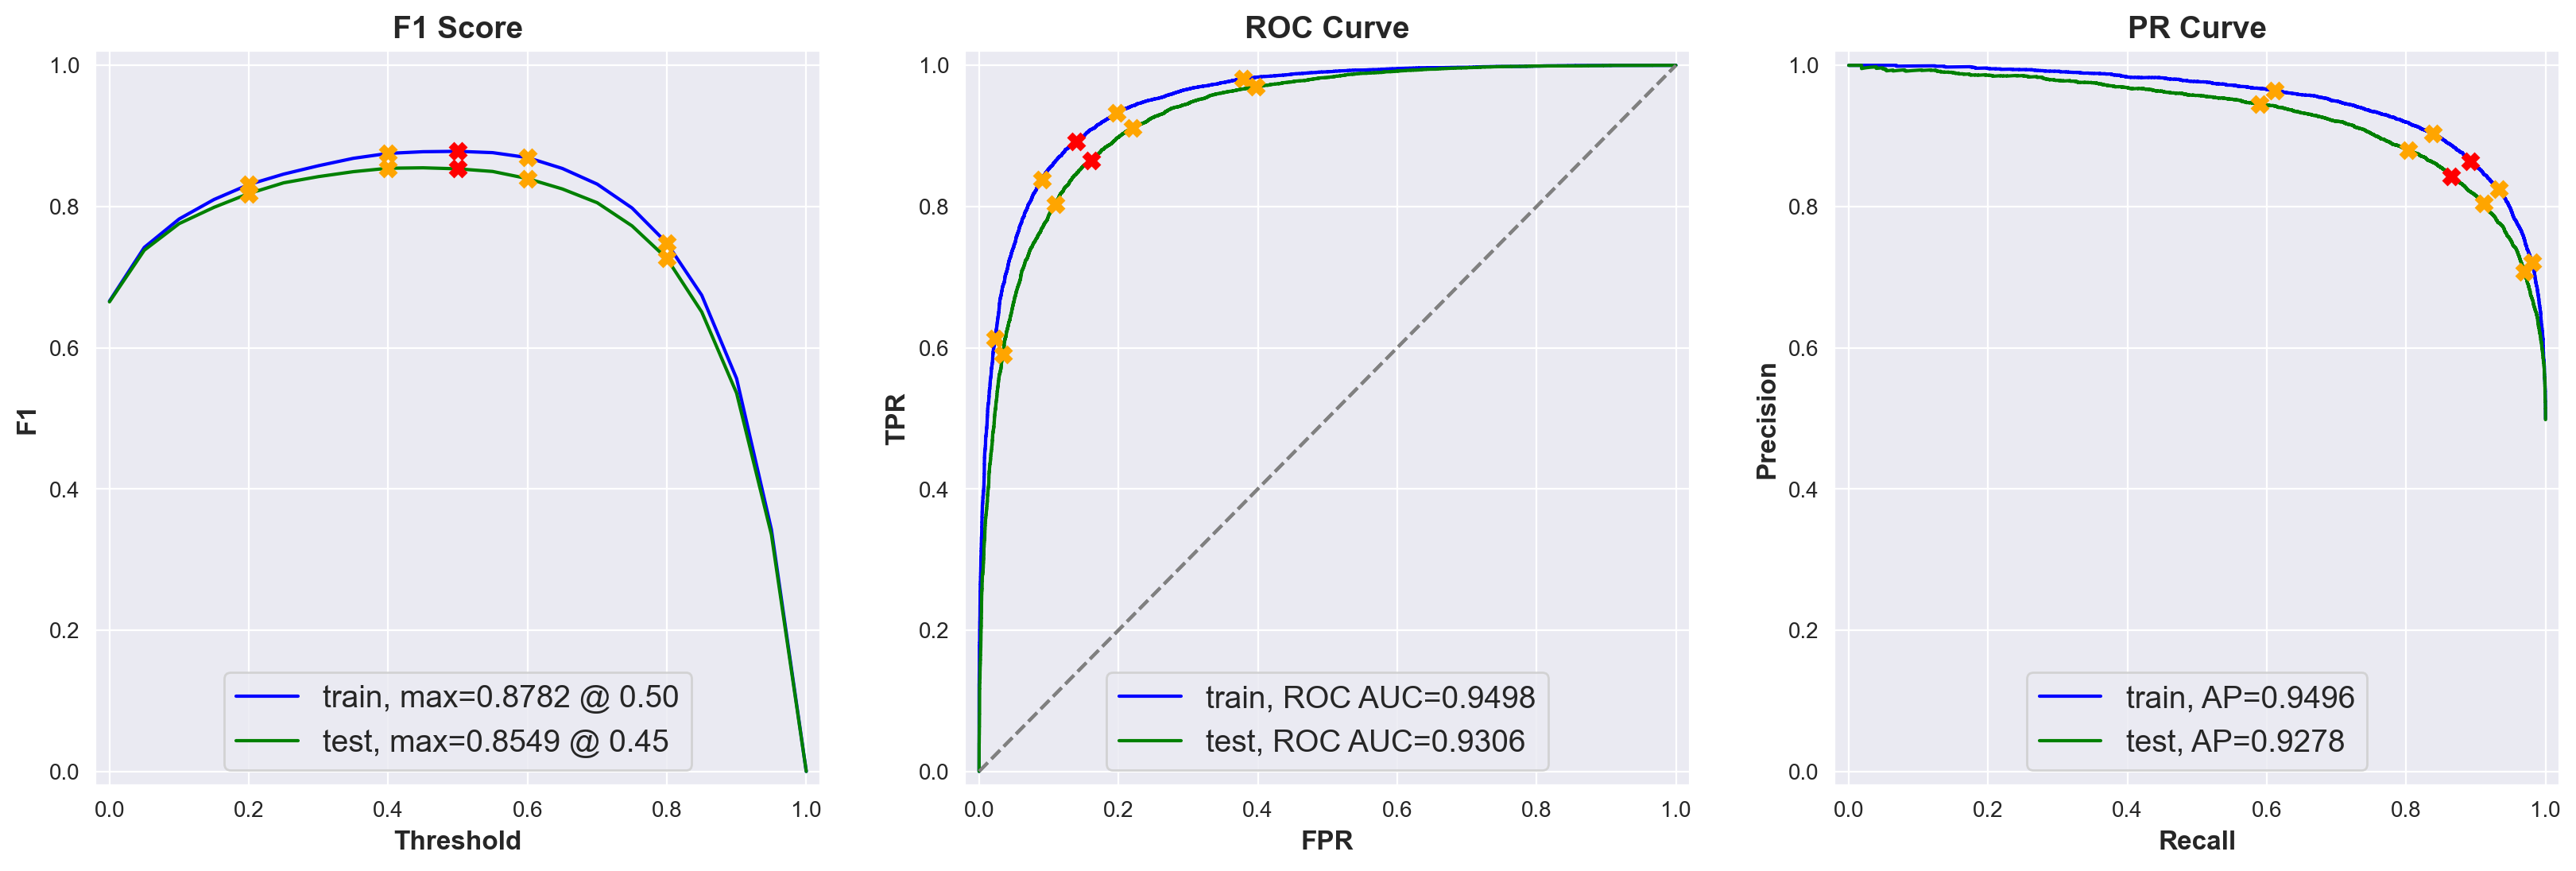

In [58]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')      
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

**For the `spacy/tf-idf` preprocessing method, the logistic regression model again outperforms the lightgbm model in terms of f1-scores and training time. Both of the models have a moderate overfitting issue. The `spacy_tfidf_lr` model has a f1-score of 0.8806 which is slighly better than the logistic regression models with `nltk/bow` and `nltk/tfidf` preprocessing methods.**

[Back to Contents](#back)

### 4.3.4 BERT <a id='bert'></a>

In [59]:
# Create a BERT model instance
BERT_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
BERT_config = transformers.BertConfig.from_pretrained('bert-base-uncased')
BERT_model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [60]:
# Create a function to preprocess text with nltk
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    '''Convert texts to embeddings with a BERT model'''
    # Get the input ids and attention masks to be fed into the BERT model
    ids_list = []
    attention_mask_list = []

    for text in texts:
        ids = BERT_tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_length)
        padded_ids = np.pad(ids, (0, max_length - len(ids)))
        attention_mask = np.where(padded_ids != 0, 1, 0)
        ids_list.append(padded_ids)
        attention_mask_list.append(attention_mask)

    # Use gpu if available
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    BERT_model.to(device)

    # Show progress bar or not
    if not disable_progress_bar:
        print(f'Using the {device} deivce')

    # Create the embeddings
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        # Convert into pytorch data format
        ids_batch = torch.LongTensor(np.array(ids_list[batch_size*i:batch_size*(i+1)])).to(device)
        attention_mask_batch = torch.LongTensor(np.array(attention_mask_list[batch_size*i:batch_size*(i+1)])).to(device)

        # Detach the input ids from computational graph for faster performance
        BERT_model.eval()
        with torch.inference_mode():
            batch_embeddings = BERT_model(ids_batch, attention_mask=attention_mask_batch)
                
        # Extract the [CLS] tokens and convert it to a numpy array
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [61]:
# The following result is obtained by using the google colab gpu
# links: https://colab.research.google.com/drive/1B7NvEzLK4r8y9pN5Jx3NJO9hqmQrLawW?usp=sharing
# Take around 30 minutes to complete the embedding task

# Embedding the text with BERT
# print('Embedding the train texts with BERT...')
# X_train_BERT = BERT_text_to_embeddings(X_train)
# print('Embedding the test texts with BERT...')
# X_test_BERT = BERT_text_to_embeddings(X_test)

# Save the embeddings
# np.savez_compressed('BERT_features.npz', X_train_BERT=X_train_BERT, X_test_BERT=X_test_BERT)

In [62]:
# Load the pretrained embeddings
with np.load('BERT_features.npz') as BERT_features:
    X_train_BERT = BERT_features['X_train_BERT']
    X_test_BERT = BERT_features['X_test_BERT']

# Find the number of features created
print('Number of features created with BERT model:', X_train_BERT.shape[1])

Number of features created with BERT model: 768


**The BERT model is reportedly to have good performances in NLP tasks, however it took longer time than the nltk and spaCy models. Let's see if the result is better.**

**Model 7 - BERT and Logistic Regression**

In [63]:
# Set up for the modeling process
model_name = 'BERT_lr'
opt_model = LogisticRegression
train_features = X_train_BERT
test_features = X_test_BERT
n_trials = 30

In [64]:
# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters = {
        'max_iter': trial.suggest_int('max_iter', 800, 800), # 2 models failed to converge with 800 iters
        'C': trial.suggest_float('C', 1e-3, 1e0, log=True)
    }

    # Train and evaluate the model
    model = opt_model(**hyperparameters)    
    cv_f1 = cross_val_score(model, train_features, y_train, scoring='f1', cv=3).mean()
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = sklearn_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising BERT_lr... :   0%|          | 0/30 [00:00<?, ?it/s]

Best hyperparameters:


{'max_iter': 800, 'C': 0.08661025596666054}

The BERT_lr model has been saved.

Evaluating the model...


train    test
Accuracy  0.8736  0.8652
F1        0.8730  0.8634
APS       0.9442  0.9385
ROC AUC   0.9439  0.9390

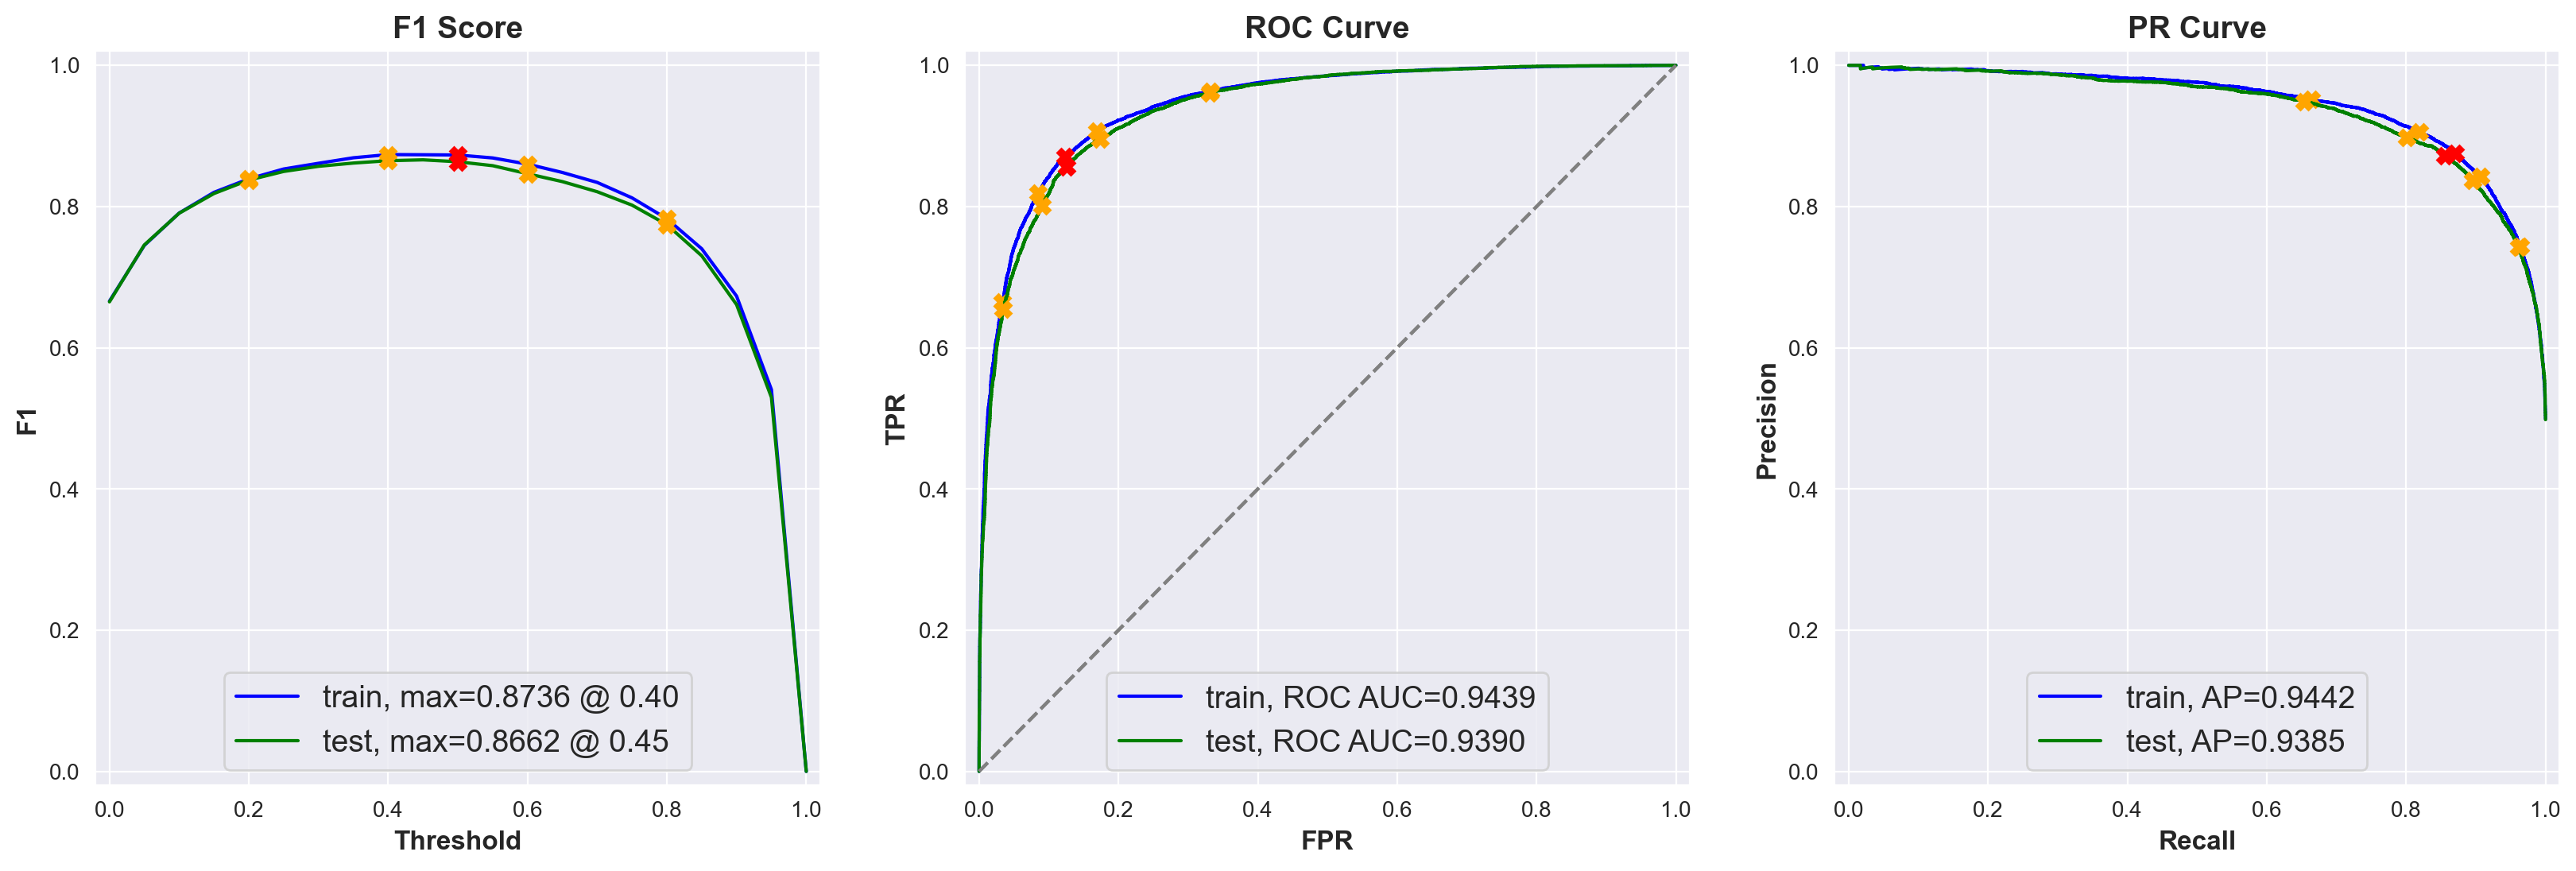

In [65]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')      
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

**With the `BERT` preprocessing method, the best test f1 score of the logistic regression is 0.8662 at the threshold of 0.45. The model does not have an obvious overfitting issus, unlike the other logistic regression models.**

**Model 8 - BERT and LightGBM**

In [66]:
# Set up for the modeling process
model_name = 'BERT_lgbm'
opt_model = LGBMClassifier
train_features = X_train_BERT
test_features = X_test_BERT
n_trials = 30

In [67]:
# Create the optuna study objective
def objective(trial):
    # Define the search space
    hyperparameters ={
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8),
        'verbose': trial.suggest_int('verbose', -1, -1)
    }

    # Train and evaluate the model
    model = opt_model(**hyperparameters)    
    cv_f1 = cross_val_score(model, train_features, y_train, scoring='f1', cv=3).mean()
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = sklearn_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising BERT_lgbm... :   0%|          | 0/30 [00:00<?, ?it/s]

Best hyperparameters:


{'max_depth': 6,
 'n_estimators': 63,
 'num_leaves': 19,
 'learning_rate': 0.2550298070162892,
 'reg_alpha': 0.0023591373063477136,
 'reg_lambda': 85.98737339212276,
 'subsample': 0.7316734307889973,
 'colsample_bytree': 0.479486272613669,
 'verbose': -1}

The BERT_lgbm model has been saved.

Evaluating the model...


train    test
Accuracy  0.8895  0.8328
F1        0.8892  0.8318
APS       0.9573  0.9135
ROC AUC   0.9563  0.9133

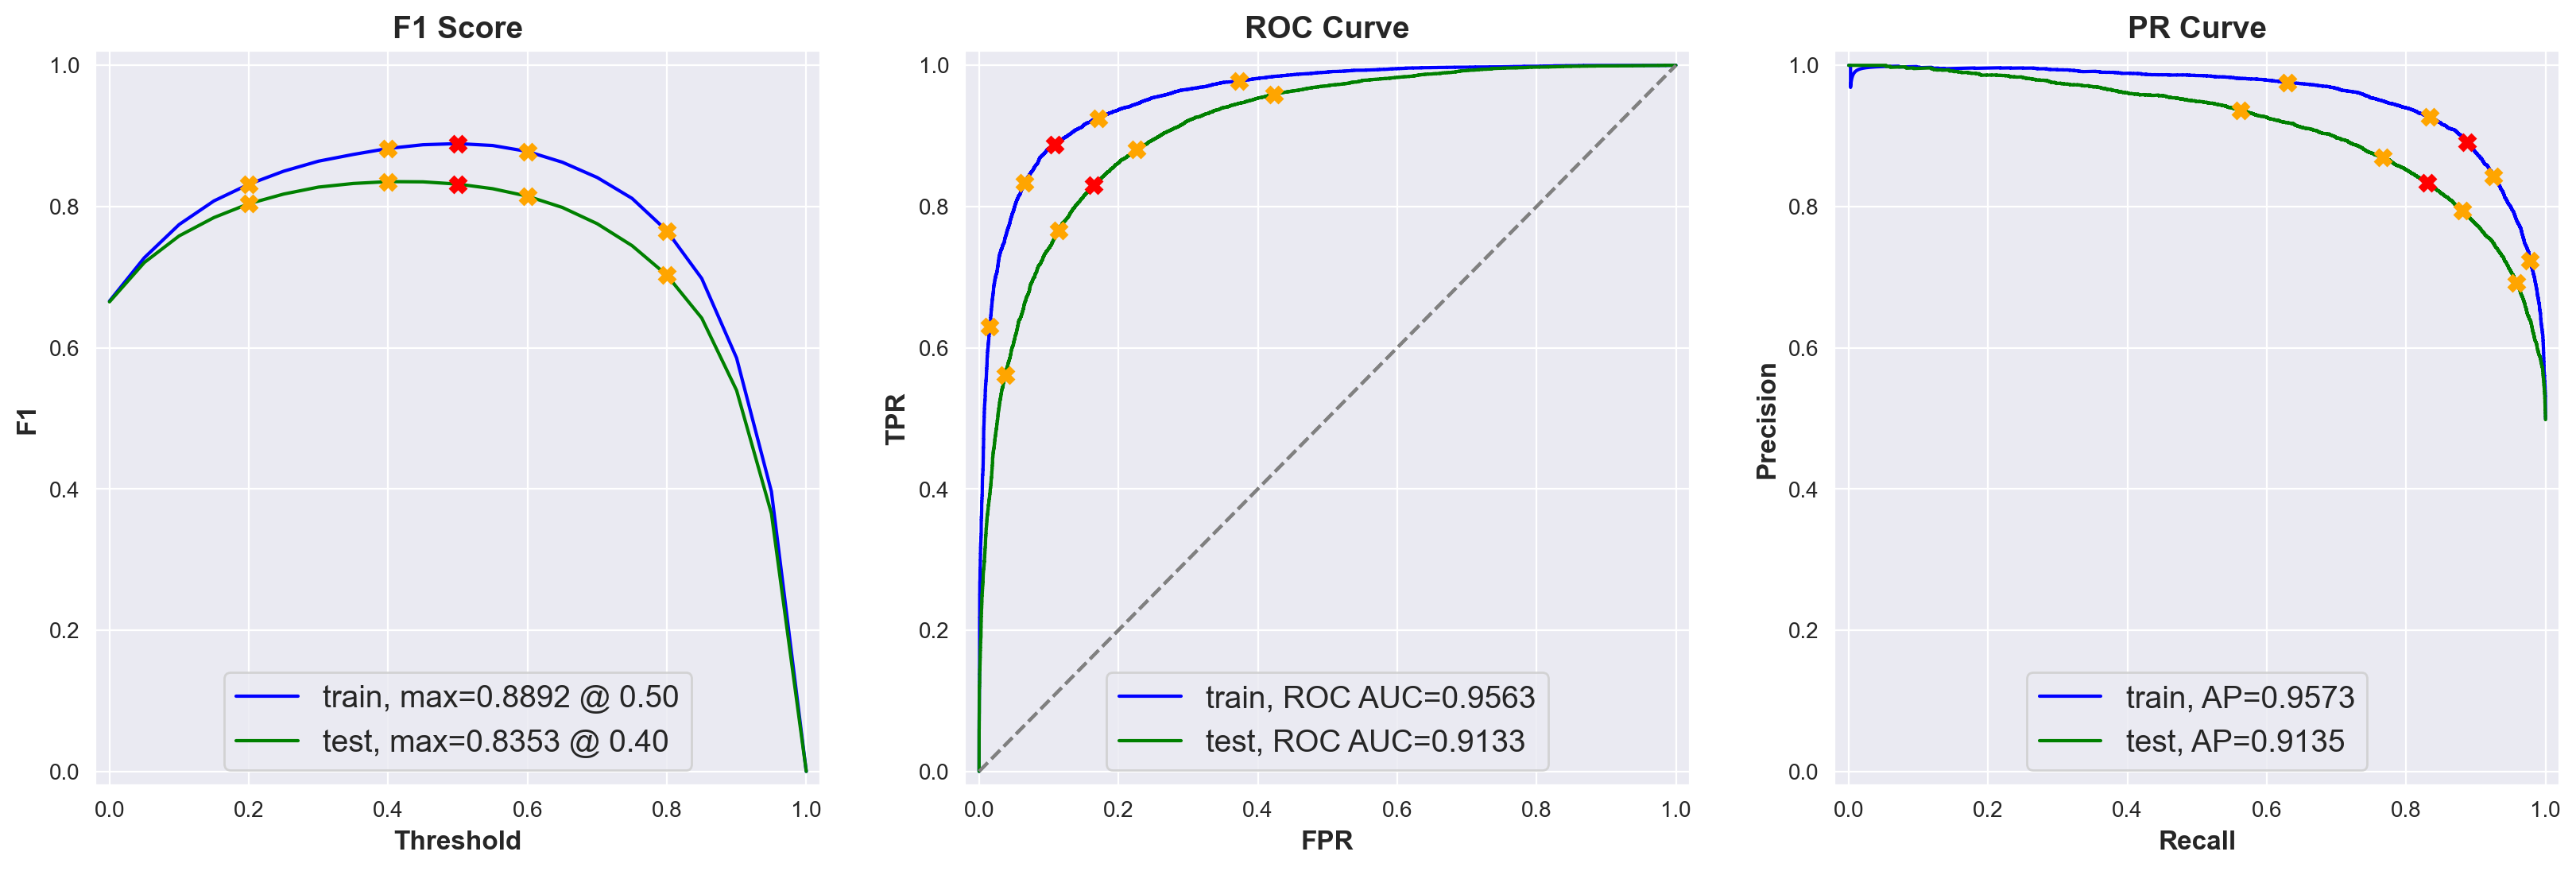

In [68]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')      
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

**The LightGBM model with the `BERT` preprocessing method has the lowest test f1-score of 0.8318.**

**Model 9 - BERT and Neural Network**

A simple neural network classifier will be built by using the Keras library. Each hidden layer consists of a `Dense` layer with a specific number of hidden units and the rectified linear unit (ReLU) as the activation function. A 'Dropout' layer is applied for each `Dense` layer in the training step to prevent overfitting. A function to create such a neural network classifier will be created.

In [69]:
def create_nn_classifier(units, hidden_layers, learning_rate, dropout_rate=None):
    '''Create a Keras binary classification model instance.'''    
    # For reproducible result
    tf.random.set_seed(42)
    kernel_initializer = tf.keras.initializers.GlorotNormal(42)

    # Create the neural network classifier
    model = Sequential()    
    for _ in range(hidden_layers):
        model.add(Dense(units, activation='relu', kernel_initializer=kernel_initializer))
        if dropout_rate is not None:
            model.add(Dropout(dropout_rate)) # prevent overfitting  
    model.add(Dense(1, activation='linear', kernel_initializer=kernel_initializer))
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

    return model

In [70]:
# Set up for the modeling process
model_name = 'BERT_nn'
opt_model = create_nn_classifier
train_features = X_train_BERT
test_features = X_test_BERT
n_trials = 30
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [71]:
# Create the optuna study objective
def objective(trial):    
    # Define the search space
    hyperparameters = {
        'units': trial.suggest_int('units', 10, 40),
        'hidden_layers': trial.suggest_int('hidden_layers', 1, 3),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5)
    }   
    epochs = trial.suggest_int('epochs', 20, 50)
    
    # Create the neural network classifier
    model = opt_model(**hyperparameters)

    # Train and evaluate the neural network classifier
    cv_f1 = 0
    for train_idx, val_idx in kfold.split(train_features, y_train):
        model.fit(train_features[train_idx], y_train.iloc[train_idx], epochs=epochs, verbose=0)
        
        y_pred = tf.round(tf.sigmoid(model.predict(train_features[val_idx], verbose=0)))
        cv_f1 += metrics.f1_score(y_train.iloc[val_idx], y_pred)    
    cv_f1 /= 3
    
    return cv_f1

# Optimise the model and store the result
best_model[model_name], train_time[model_name] = keras_opt(
    opt_model, objective, n_trials, 'maximize', train_features, y_train, model_name
)

Optimising BERT_nn... :   0%|          | 0/30 [00:00<?, ?it/s]




Best hyperparameters:


{'units': 33,
 'hidden_layers': 1,
 'learning_rate': 0.001355269159246648,
 'dropout_rate': 0.1368518618107344,
 'epochs': 32}

The BERT_nn model has been saved.

Evaluating the model...


train    test
Accuracy  0.9138  0.8593
F1        0.9145  0.8600
APS       0.9744  0.9363
ROC AUC   0.9734  0.9370

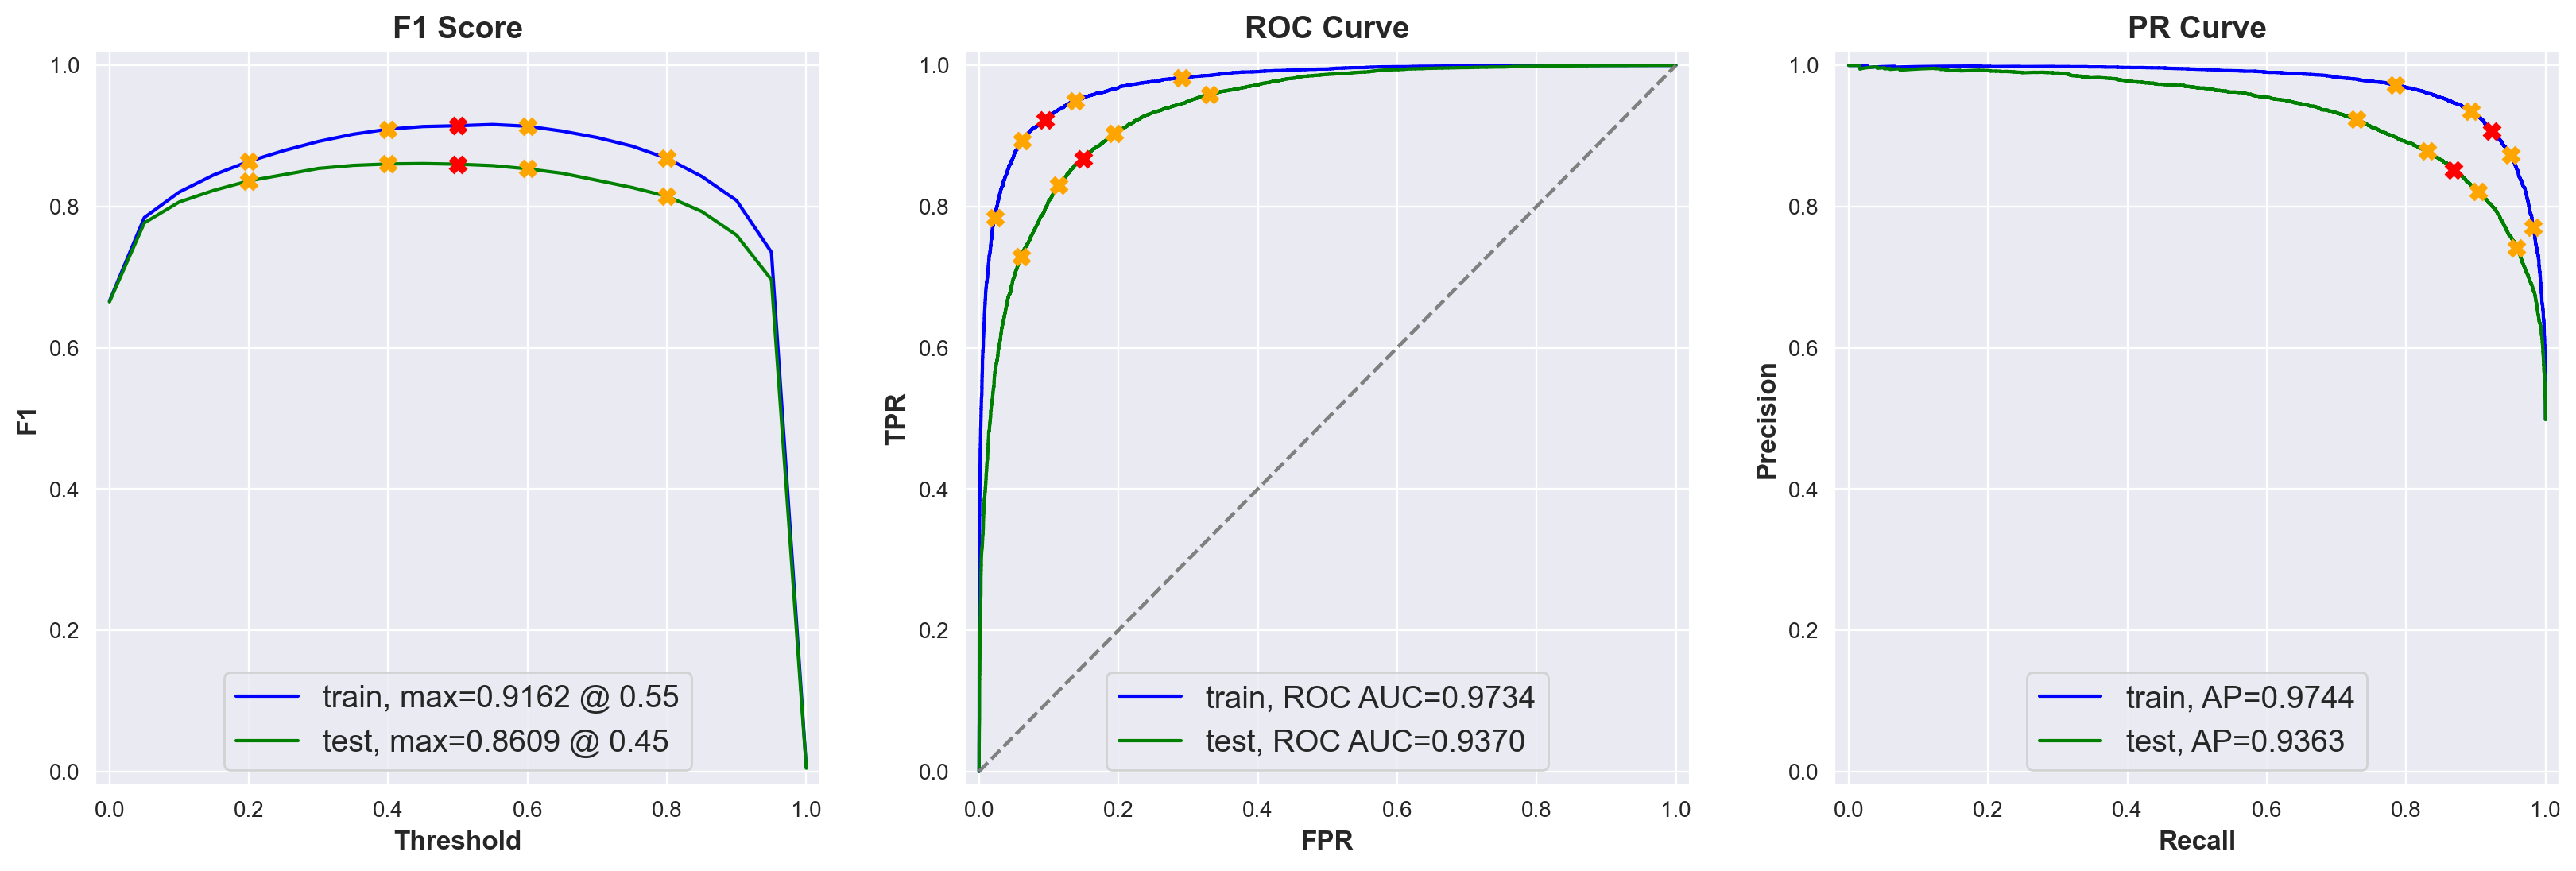

In [72]:
# Save or load the optimised model
model_path = model_folder / f'project_14_{model_name}.pkl'

try:
    pickle.dump(best_model[model_name], open(model_path, 'wb'))    
    print(f'The {model_name} model has been saved.\n')    
except:
    best_model[model_name] = pickle.load(open(model_path, 'rb'))
    print(f'The {model_name} model has been loaded.\n')

# Evaluate the model
result[model_name] = evaluate_model(best_model[model_name], train_features, y_train, test_features, y_test)

**Surprisingly, all of the three models does not have better f1-scores compared to the models with nltk or spaCy preprocessing methods. With BERT text embeddings, the logistic regression is still the best model.**

[Back to Contents](#back)

### 4.4 Final Evaluation <a id='final_eval'></a>

In [73]:
# Save the train time if all the 10 models went through the optimisation process 
# Else load the pre-saved train time
train_time_path = 'project_14_train_time.pkl'

if len(train_time) == 10:
    pickle.dump(train_time, open(train_time_path, 'wb'))   
    print(f'All ten model traning times have been saved.')    
else:
    train_time = pickle.load(open(train_time_path, 'rb'))
    print(f'All ten model training times have been loaded.')

All ten model traning times have been saved.


In [74]:
# Create the dataframe to store the result
result_df = pd.DataFrame(result).transpose()
result_df = result_df.merge(pd.DataFrame([train_time]).transpose(), left_index=True, right_index=True)
result_df = result_df.rename(columns={0: 'training_time (ms)'})

# Have a look at the final result
result_df = result_df.sort_values('test_f1', ascending=False)
result_df

train_f1  test_f1  prediction_time (ms)  training_time (ms)
spacy_tfidf_lr      0.9262   0.8806                   9.0                1794
nltk_tfidf_lr       0.9357   0.8792                  16.0                 890
nltk_bow_lr         0.9393   0.8788                   6.0                1496
BERT_lr             0.8730   0.8634                  72.0               11799
BERT_nn             0.9145   0.8600                 953.0               28259
nltk_tfidf_lgbm     0.8993   0.8595                  24.0                6848
nltk_bow_lgbm       0.8702   0.8560                  16.0                2919
spacy_tfidf_lgbm    0.8782   0.8534                  28.0                5466
BERT_lgbm           0.8892   0.8318                  47.0                3006
constant            0.0000   0.0000                   0.0                   1

Let's visualise the final result.

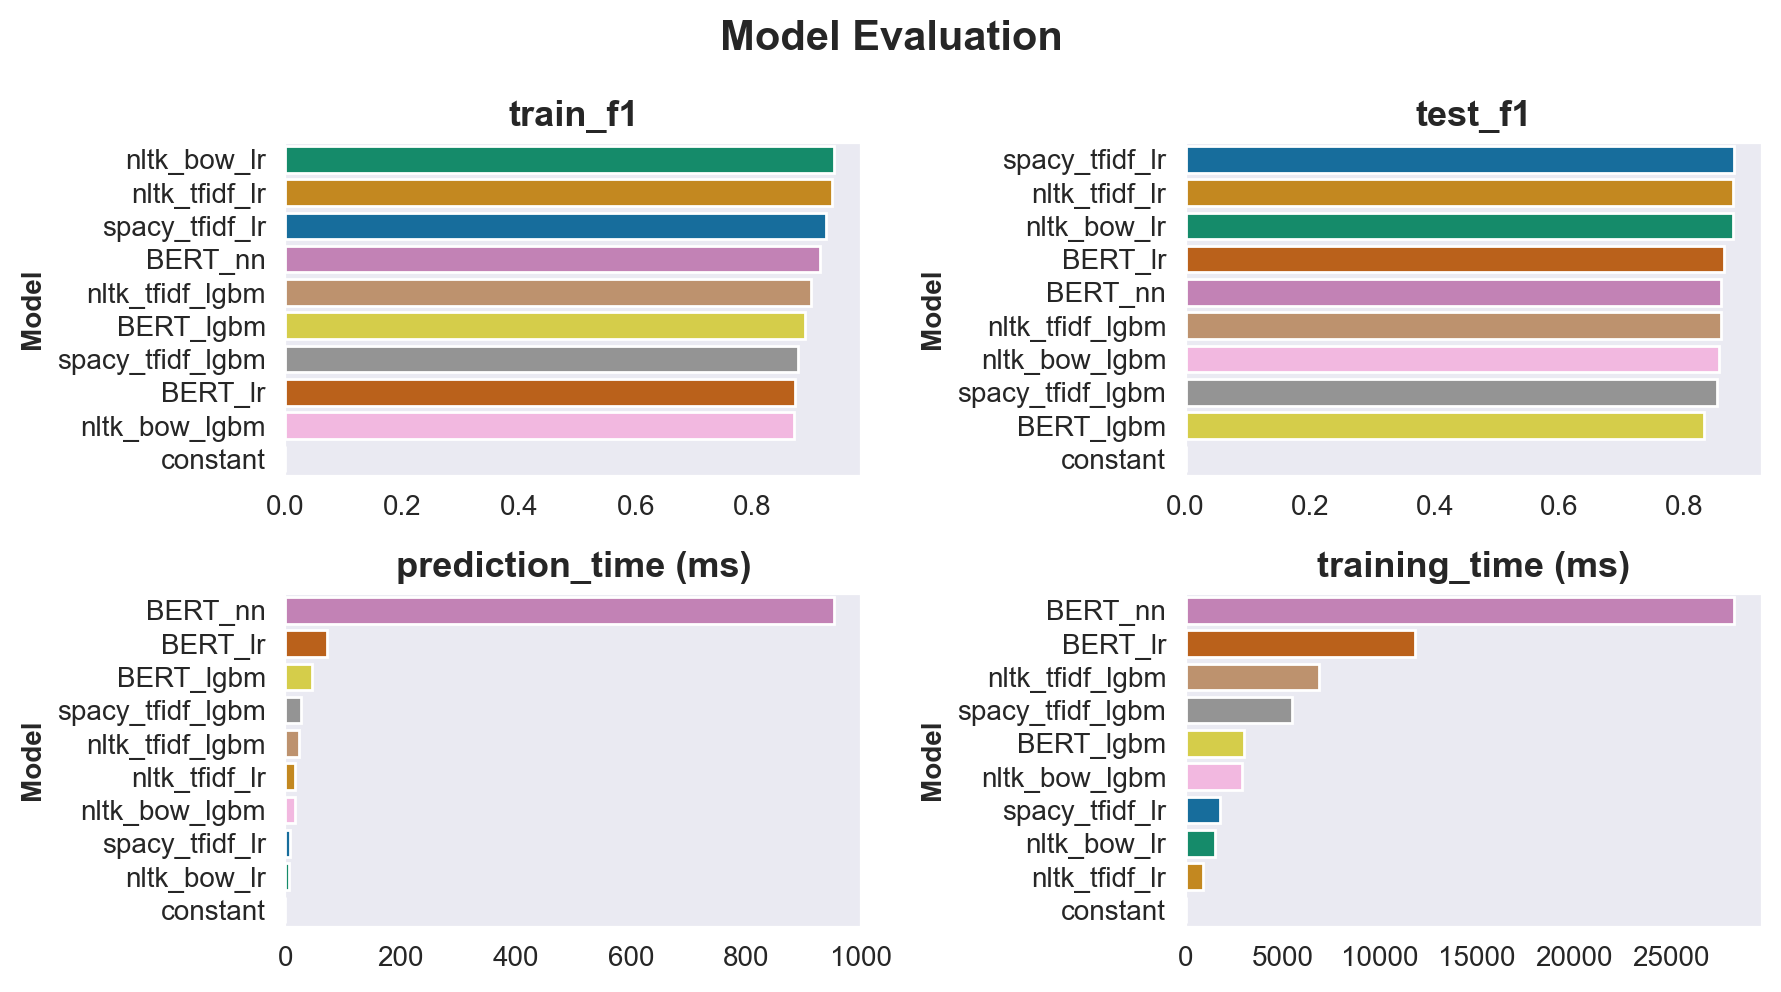

In [75]:
# Plot bar charts to visualise the result
# Set up the figure
sns.set_style('dark')
n_rows, n_cols = 2, 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(9, 5))

fig.suptitle('Model Evaluation', fontsize=15, fontweight='bold')

# Assign colors for models
colors = sns.color_palette('colorblind')
model_colors = {}
for i, model in enumerate(result_df.index):
    color = colors[i % len(colors)]
    model_colors[model] = color

# Plot the bar charts
for i in range(n_rows):
    for j in range(n_cols):
        plot_column = result_df.columns[i*n_cols + j]
        plot_data = result_df[plot_column].sort_values(ascending=False)
        
        ax = axs[i][j]
        sns.barplot(y=plot_data.index, x=plot_data.values, hue=plot_data.index, palette=model_colors, ax=ax)
        ax.set_title(plot_column, fontsize=13, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('Model', fontweight='bold')

fig.tight_layout()
plt.show()

**Model Evaluation**

- All of the models, except the `constant` and the `BERT_lgbm`, achieved the minimum test f1-score of 0.85. Generally, the logistic regression models have better f1-scores regardless the text preprocessing methods. However, most of them have an obvious overfitting issue except the `BERT-lr`. The models with the BERT text embeddings have worse test fl-scores than the other text preprocessing methods.
- In terms of training time and prediction time, the logistic regression models are generally faster than the rests except the `BERT_lr`model.
- **The `spacy_tfidf_lr` model has the best test f1-score of 0.8806 and a short prediciton time.**

Let's have a look at the confusion matrices of the various logistic regression models.

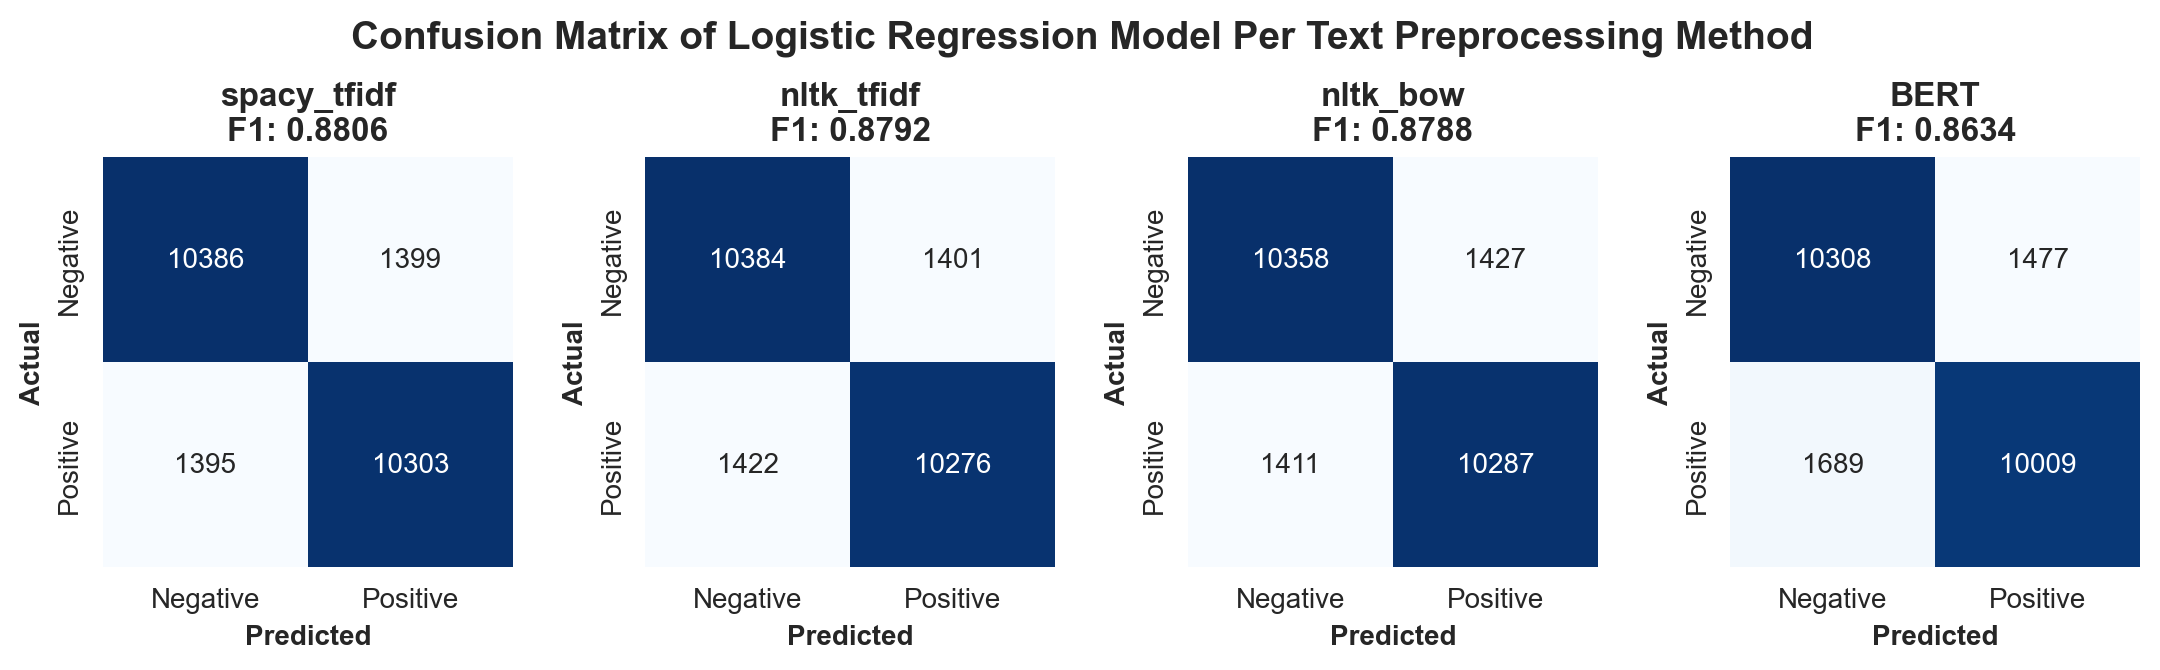

In [76]:
fig, axs = plt.subplots(1, 4, figsize=(11, 3))

fig.suptitle('Confusion Matrix of Logistic Regression Model Per Text Preprocessing Method', y=1.02,
             fontsize=14, fontweight='bold')

preprocess_all = ['spacy_tfidf', 'nltk_tfidf', 'nltk_bow', 'BERT']
X_test_all = [X_test_spacy_tfidf, X_test_nltk_tfidf, X_test_nltk_bow, X_test_BERT]

for i, (preprocess, X) in enumerate(zip(preprocess_all, X_test_all)):
    y_pred = best_model[f'{preprocess}_lr'].predict(X)
    ax = axs[i]
    sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', square=True, cmap='Blues', cbar=False, ax=axs[i])
    ax.set_title(f'{preprocess}\nF1: {result_df.loc[f"{preprocess}_lr", "test_f1"]}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontweight='bold')
    ax.set_xlabel('Predicted', fontweight='bold')
    ax.set_xticks([0.5, 1.5], ['Negative', 'Positive'])
    ax.set_yticks([0.5, 1.5], ['Negative', 'Positive'])

fig.tight_layout()
plt.show()

All of the logistic regression models have similar performances except that the `BERT_lr` model has more misclassified positive labels.

[Back to Contents](#back)

## 5. My Reviews <a id='my_reviews'></a>

Let's create some random reviews and test them with the four logistic regression models.

In [77]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'The movie featured solid acting and an average plot, offering a somewhat neutral but overall enjoyable experience.',
    'I didn\'t connect with the characters; the plot felt contrived, and the ending disappointed.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: ' '.join(re.sub(r"[^a-zA-Z']", ' ', x).lower().split()))
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1, 1, 0]

my_reviews

review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and felt asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   
5  The movie had its upsides and downsides, but I...   
6  What a rotten attempt at a comedy. Not a singl...   
7  Launching on Netflix was a brave move & I real...   
8  The movie featured solid acting and an average...   
9  I didn't connect with the characters; the plot...   

                                         review_norm  pos  
0      i did not simply like it not my kind of movie    0  
1  well i was bored and felt asleep in the middle...    0  
2             i was really fascinated with the movie    1  
3  even the actors looked really old and disinter...    0  
4  i didn't expect the reboot to be so good write...    1  
5  the movie had its upsides and downsides but i ...    1  
6  what a rotten attempt at a comedy not a single...    0  
7  launching on netflix was a brave move i really...    1  
8  the movie featured solid acting and an average...    1  
9  i didn't connect with the characters the plot ...    0

**Model 1 - NLTK, Bag-of-Words and Logistic Regression**

In [78]:
my_reviews_model = best_model['nltk_bow_lr']
my_reviews_features = nltk_count_vectorizer.transform(my_reviews['review_norm'].apply(nltk_text_preprocessing))

my_reviews_pred_prob = my_reviews_model.predict_proba(my_reviews_features)[:, 1]

print('pos\t pred_proba\t review')
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews["pos"][i]}\t {my_reviews_pred_prob[i]:.2f}\t\t {review}')

print('\nTotal predictions:', len(my_reviews))
print('Number of correct predictions:', (np.round(my_reviews_pred_prob) == my_reviews['pos']).sum())

pos	 pred_proba	 review
0	 0.44		 i did not simply like it not my kind of movie
0	 0.37		 well i was bored and felt asleep in the middle of the movie
1	 0.49		 i was really fascinated with the movie
0	 0.30		 even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1	 0.43		 i didn't expect the reboot to be so good writers really cared about the source material
1	 0.54		 the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0	 0.21		 what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1	 0.73		 launching on netflix was a brave move i really appreciate being able to binge on episode after episo
1	 0.68		 the movie featured solid acting and an average plot offering a somewhat neutral but overall enjoyabl
0	 0.31		 i didn't connect with the characters the plot felt contrived and the ending disappointed

Total predictions: 10
Number of correct predicti

**Model 3 - NLTK, TF-IDF and Logistic Regression**

In [79]:
my_reviews_model = best_model['nltk_tfidf_lr']
my_reviews_features = nltk_tfidf_vectorizer.transform(my_reviews['review_norm'].apply(nltk_text_preprocessing))

my_reviews_pred_prob = my_reviews_model.predict_proba(my_reviews_features)[:, 1]

print('pos\t pred_proba\t review')
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews["pos"][i]}\t {my_reviews_pred_prob[i]:.2f}\t\t {review}')

print('\nTotal predictions:', len(my_reviews))
print('Number of correct predictions:', (np.round(my_reviews_pred_prob) == my_reviews['pos']).sum())

pos	 pred_proba	 review
0	 0.16		 i did not simply like it not my kind of movie
0	 0.14		 well i was bored and felt asleep in the middle of the movie
1	 0.46		 i was really fascinated with the movie
0	 0.12		 even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1	 0.30		 i didn't expect the reboot to be so good writers really cared about the source material
1	 0.53		 the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0	 0.04		 what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1	 0.87		 launching on netflix was a brave move i really appreciate being able to binge on episode after episo
1	 0.78		 the movie featured solid acting and an average plot offering a somewhat neutral but overall enjoyabl
0	 0.07		 i didn't connect with the characters the plot felt contrived and the ending disappointed

Total predictions: 10
Number of correct predicti

**Model 5 - spaCy, TF-IDF and Logistic Regression**

In [80]:
my_reviews_model = best_model['spacy_tfidf_lr']
my_reviews_features = spacy_tfidf_vectorizer.transform(my_reviews['review_norm'].apply(spacy_text_preprocessing))

my_reviews_pred_prob = my_reviews_model.predict_proba(my_reviews_features)[:, 1]

print('pos\t pred_proba\t review')
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews["pos"][i]}\t {my_reviews_pred_prob[i]:.2f}\t\t {review}')

print('\nTotal predictions:', len(my_reviews))
print('Number of correct predictions:', (np.round(my_reviews_pred_prob) == my_reviews['pos']).sum())

pos	 pred_proba	 review
0	 0.17		 i did not simply like it not my kind of movie
0	 0.23		 well i was bored and felt asleep in the middle of the movie
1	 0.48		 i was really fascinated with the movie
0	 0.15		 even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1	 0.19		 i didn't expect the reboot to be so good writers really cared about the source material
1	 0.68		 the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0	 0.03		 what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1	 0.87		 launching on netflix was a brave move i really appreciate being able to binge on episode after episo
1	 0.81		 the movie featured solid acting and an average plot offering a somewhat neutral but overall enjoyabl
0	 0.15		 i didn't connect with the characters the plot felt contrived and the ending disappointed

Total predictions: 10
Number of correct predicti

**Model 7 - BERT and Logistic Regression**

In [81]:
my_reviews_model = best_model['BERT_lr']
my_reviews_features = BERT_text_to_embeddings(my_reviews['review_norm'])

my_reviews_pred_prob = my_reviews_model.predict_proba(my_reviews_features)[:, 1]

print('pos\t pred_proba\t review')
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews["pos"][i]}\t {my_reviews_pred_prob[i]:.2f}\t\t {review}')

print('\nTotal predictions:', len(my_reviews))
print('Number of correct predictions:', (np.round(my_reviews_pred_prob) == my_reviews['pos']).sum())

Using the cuda deivce


  0%|          | 0/1 [00:00<?, ?it/s]

pos	 pred_proba	 review
0	 0.25		 i did not simply like it not my kind of movie
0	 0.01		 well i was bored and felt asleep in the middle of the movie
1	 0.96		 i was really fascinated with the movie
0	 0.00		 even the actors looked really old and disinterested and they got paid to be in the movie what a soul
1	 0.18		 i didn't expect the reboot to be so good writers really cared about the source material
1	 0.94		 the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0	 0.05		 what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1	 0.94		 launching on netflix was a brave move i really appreciate being able to binge on episode after episo
1	 0.38		 the movie featured solid acting and an average plot offering a somewhat neutral but overall enjoyabl
0	 0.08		 i didn't connect with the characters the plot felt contrived and the ending disappointed

Total predictions: 10
Number of correct predicti

All the logistic regression models have 8 predictions correct out of 10. None of the model correctly classified the review 'i didn't expect the reboot to be so good writers really cared about the source material' as a positive review. Despite having the lowest test f1-score, the `BERT_lr` model has higher certainty in its predictions.

[Back to Contents](#back)

## 6. Model Deployment <a id='model_deployment'></a>

The best model in this project is the `spacy_tfidf_lr` classifier with the f1-score of 88.06. The model will be deployed with the Streamlit app. To do so, we will save the text preprocessing model `spacy_tfidf_vectorizer`  and the classifier `spacy_tfidf_lr`.

In [82]:
# Save the text preprocessing model
spacy_tfidf_vectorizer_path = model_folder / 'project_14_spacy_tfidf_vectorizer.pkl'
pickle.dump(spacy_tfidf_vectorizer, open(spacy_tfidf_vectorizer_path, 'wb'))
print('The text preprocessing model has been saved.')

The text preprocessing model has been saved.


In [83]:
# The spacy_tfidf_lr has been saved earlier, let's have a check
if Path('models/project_14_spacy_tfidf_lr.pkl').is_file():
    print('The model has been saved.')
else:
    print('Warning! The model does not exist.')

The model has been saved.


The model has been successfully deployed. Have a try with the link [Sentiment Analysis on a Movie Review](https://moviereviewpolarityapppy-estdryd4emjykb4gz99yk9.streamlit.app/) .

[Back to Contents](#back)

## 7. General Conclusion <a id='general_conclusion'></a>

**Data Exploration and Preprocessing**

The dataset has 47331 reviews and related information. There are 91 duplicates reviews and have been dropped.

**Exploratory Data Analysis**

In this stage, the following patterns/results have been observed:

- The number of movies per year was less than 50 before 1970. After 1970, the number of movies has been increasing gradually until 2006.
- The average number of reviews per movie was between 4 to 6 before 1960 and 6 to 8 after 1970.
- Starting from 1990s, there is an increasing trend in the number of reviews with negative polarity.
- - The `drama` and `comedy` are the two most popular genres and there are more positive reviews for these genres (especially the `drama`).
- The `action`, `horror`, `thriller` and `sci-fi` genres apparently have more negative reviews.
- Generally, the movies with positive reviews have significantly higher ratings than the negative ones, regardless the movie genres.
- The train and test sets have similar distributions of ratings and number of reviews, which are essential to create a effective machine learning model.
- The dataset has no issue of imbalanced classes.

**Model Development**

- The reviews have been preprocessed by text normalisation by changing all the texts to lowercase and removing all the punctuation marks except `'`. These reviews are then further processed by one of the four models: nltk and bag-of-words, nltk and tf-idf, spacy and tf-idf, BERT. For each method, two models namely logistic regression and lightgbm have been developed. Besides that, an additional neural network classifier has been developed for the `BERT` method. Including a constant model, a total of ten models have been built.

**Model Evaluation**

- The f1-score was the main evaluation metric, other evaluation metrics included accuracy, average precision and ROC-AUC.
- All of the models, except the `constant` and the `BERT_lgbm`, achieved the minimum test f1-score of 0.85. The logistic regression models have the best test f1-scores regardless the text preprocessing method. The models with the BERT text embeddings have worse test fl-scores than the other text preprocessing methods.
- In terms of training time and prediction time, the logistic regression models are faster than the rests except the `BERT_lr`model.
- **The `spacy_tfidf_lr` model has the best test f1-score of 0.8806 and a short prediciton time.**

**Model Deployment**

The model has been successfully deployed by using the Streamlit app. Have a try with the link [Sentiment Analysis on a Movie Review](https://moviereviewpolarityapppy-estdryd4emjykb4gz99yk9.streamlit.app/) .

[Back to Contents](#back)